# Callbacks and Events

In working with a differential equation, our system will evolve through many states. Particular states of the system may be of interest to us, and we say that an ***"event"*** is triggered when our system reaches these states. For example, events may include the moment when our system reaches a particular temperature or velocity. We ***handle*** these events with ***callbacks***, which tell us what to do once an event has been triggered.

These callbacks allow for a lot more than event handling, however. For example, we can use callbacks to achieve high-level behavior like exactly preserve conservation laws and save the trace of a matrix at pre-defined time points. This extra functionality allows us to use the callback system as a modding system for the DiffEq ecosystem's solvers. 

This tutorial is an introduction to the callback and event handling system in DifferentialEquations.jl, documented in the [Event Handling and Callback Functions](http://docs.juliadiffeq.org/latest/features/callback_functions.html) page of the documentation. We will also introduce you to some of the most widely used callbacks in the [Callback Library](http://docs.juliadiffeq.org/latest/features/callback_library.html), which is a library of pre-built mods.

## Events and Continuous Callbacks

Event handling is done through continuous callbacks. Callbacks take a function, `condition`, which triggers an `affect!` when `condition == 0`. These callbacks are called "continuous" because they will utilize rootfinding on the interpolation to find the "exact" time point at which the condition takes place and apply the `affect!` at that time point.

***Let's use a bouncing ball as a simple system to explain events and callbacks.*** Let's take Newton's model of a ball falling towards the Earth's surface via a gravitational constant `g`. In this case, the velocity is changing via `-g`, and position is changing via the velocity. Therefore we receive the system of ODEs:

In [2]:
using DifferentialEquations
ball! = @ode_def BallBounce begin
  dy =  v
  dv = -g
end g

(::BallBounce) (generic function with 8 methods)

We want the callback to trigger when `y=0` since that's when the ball will hit the Earth's surface -- our event. We do this with the condition:

In [5]:
function condition(u,t,integrator) # Event when event_f(u,t) == 0
  u[1]
end

condition (generic function with 1 method)

Recall that the `condition` will trigger when it evaluates to zero, and here it will evaluate to zero when `u[1] == 0`, which occurs when `v == 0`. *Now we have to say what we want the callback to do.* Callbacks make use of the [Integrator Interface](http://docs.juliadiffeq.org/latest/basics/integrator.html). Instead of giving a full description, a quick and usable rundown is:

- Values are strored in `integrator.u`
- Times are stored in `integrator.t`
- The parameters are stored in `integrator.p`
- `integrator(t)` performs an interpolation in the current interval between `integrator.tprev` and `integrator.t` (and allows extrapolation)
- User-defined options (tolerances, etc.) are stored in `integrator.opts`
- `integrator.sol` is the current solution object. Note that `integrator.sol.prob` is the current problem

While there's a lot more on the integrator interface page, that's a working knowledge of what's there.

What we want to do with our `affect!` is to "make the ball bounce". Mathematically speaking, the ball bounces when the sign of the velocity flips. As an added behavior, let's also use a small friction constant to dampen the ball's velocity. This way only a percentage of the velocity will be retained when the event is triggered and the callback is used.  We'll define this behavior in the `affect!` function:

In [37]:
function affect!(integrator)
    integrator.u[2] = -integrator.p[2] * integrator.u[2]
end

affect! (generic function with 1 method)

`integrator.u[2]` is the second value of our model, which is `v` or velocity, and `integrator.p[2]`, is our friction coefficient.

Therefore `affect!` can be read as follows: `affect!` will take the current value of velocity, and multiply it `-1` multiplied by our friction coefficient. Therefore the ball will change direction and its velocity will dampen when `affect!` is called.

Now let's build the `ContinuousCallback`:

In [41]:
bounce_cb = ContinuousCallback(condition,affect!)

DiffEqBase.ContinuousCallback{#condition,#affect!,#affect!,DiffEqBase.#INITIALIZE_DEFAULT,Float64,Int64,Void}(condition, affect!, affect!, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, (true, true), 1.0e-9, 0)

Now let's make an `ODEProblem` which has our callback:

In [42]:
u0 = [50.0,0.0]
tspan = (0.0,15.0)
p = (9.8,0.9)
prob = ODEProblem(ball!,u0,tspan,p,callback=bounce_cb)

DiffEqBase.ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 15.0)
u0: [50.0, 0.0]

Notice that we chose a friction constant of `0.9`. Now we can solve the problem and plot the solution as we normally would:

In [43]:
sol = solve(prob,Tsit5())
using Plots; gr()
plot(sol)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 5 
 
 
 10 
 
 
 15 
 
 
 -20 
 
 
 0 
 
 
 20 
 
 
 40 
 
 
 t 
 
<polyline clip-path="url(#clip1302)" style="stroke:#009af9; stroke-width:3; stroke-opacity:1; fill:none" points="
 35.8488,11.811 36.3938,11.8158 36.9388,11.83 37.4838,11.8537 38.0288,11.8868 38.5738,11.9295 39.1188,11.9816 39.6639,12.0432 40.2089,12.1143 40.7539,12.1948 
 41.2989,12.2848 41.8439,12.3843 42.3889,12.4933 42.9339,12.6118 43.4789,12.7397 44.0239,12.8771 44.569,13.024 45.114,13.1804 45.659,13.3462 46.204,13.5215 
 46.749,13.7063 47.294,13.9006 47.839,14.1043 48.384,14.3175 48.929,14.5402 49.4741,14.7724 50.0191,15.0141 50.5641,15.2652 51.1091,15.5258 51.6541,15.7959 
 52.1991,16.0754 52.7441,16.3644 53.2891,16.6629 53.8341,16.9709 54.3792,17.2884 54.9242,17.6153 55.4692,17.9517 56.0142,18.2976 56.5592,18.653 57.1042,19.0178 
 57.6492,19.3922 58.1942,19.7759 58.7392,20.1692 59.2843,20.572 59.8293,20.9842 60.3743,21.4059 60.9193,21.8371 61.4643,22.2777 62.0093,22.7278 62.5543,23.1875 
 63.0993,23.6565 63.6443,24.1351 64.1894,24.6231 64.7344,25.1206 65.2794,25.6276 65.8244,26.1441 66.3694,26.67 66.9144,27.2055 67.4594,27.7503 68.0044,28.3047 
 68.5494,28.8686 69.0945,29.4419 69.6395,30.0247 70.1845,30.617 70.7295,31.2187 71.2745,31.8299 71.8195,32.4506 72.3645,33.0808 72.9095,33.7205 73.4545,34.3696 
 73.9996,35.0282 74.5446,35.6963 75.0896,36.3739 75.6346,37.0609 76.1796,37.7574 76.7246,38.4634 77.2696,39.1789 77.8146,39.9038 78.3596,40.6383 78.9047,41.3822 
 79.4497,42.1355 79.9947,42.8984 80.5397,43.6707 81.0847,44.4525 81.6297,45.2438 82.1747,46.0446 82.7197,46.8548 83.2647,47.6745 83.8098,48.5037 84.3548,49.3423 
 84.8998,50.1905 85.4448,51.0481 85.9898,51.9152 86.5348,52.7918 87.0798,53.6778 87.6248,54.5733 88.1698,55.4783 88.7149,56.3928 89.2599,57.3167 89.8049,58.2502 
 90.3499,59.1931 90.8949,60.1455 91.4399,61.1073 91.9849,62.0786 92.5299,63.0595 93.0749,64.0497 93.62,65.0495 94.165,66.0587 94.71,67.0775 95.255,68.1056 
 95.8,69.1433 96.345,70.1905 96.89,71.2471 97.435,72.3132 97.98,73.3887 98.5251,74.4738 99.0701,75.5683 99.6151,76.6723 100.16,77.7858 100.705,78.9088 
 101.25,80.0412 101.795,81.1831 102.34,82.3345 102.885,83.4953 103.43,84.6657 103.975,85.8455 104.52,87.0348 105.065,88.2335 105.61,89.4418 106.155,90.6595 
 106.7,91.8867 107.245,93.1234 107.79,94.3695 108.335,95.6251 108.88,96.8902 109.425,98.1648 109.97,99.4489 110.515,100.742 111.06,102.045 111.605,103.358 
 112.15,104.68 112.695,106.011 113.24,107.352 113.785,108.703 114.33,110.062 114.875,111.432 115.42,112.811 115.965,114.199 116.51,115.597 117.055,117.004 
 117.6,118.421 118.145,119.847 118.69,121.283 119.235,122.728 119.78,124.182 120.326,125.646 120.871,127.12 121.416,128.603 121.961,130.096 122.506,131.598 
 123.051,133.109 123.596,134.63 124.141,136.16 124.686,137.7 125.231,139.25 125.776,140.809 126.321,142.377 126.866,143.955 127.411,145.542 127.956,147.139 
 128.501,148.745 129.046,150.361 129.591,151.986 130.136,153.621 130.681,155.265 131.226,156.919 131.771,158.582 132.316,160.254 132.861,161.936 133.406,163.628 
 133.951,165.329 134.496,167.039 135.041,168.759 135.586,170.489 136.131,172.228 136.676,173.976 137.221,175.734 137.766,177.501 138.311,179.278 138.856,181.064 
 139.401,182.86 139.946,184.666 140.491,186.48 141.036,188.304 141.581,190.138 142.126,191.981 142.671,193.834 143.216,195.696 143.761,197.568 144.306,199.449 
 144.851,201.339 145.396,203.239 145.941,205.149 146.486,207.068 147.031,208.996 147.576,210.934 148.121,212.882 148.666,214.838 149.211,216.805 149.756,218.781 
 150.301,220.766 150.846,222.761 151.391,224.765 151.936,225.805 152.481,223.998 153.026,222.2 153.571,220.412 154.116,218.633 154.661,216.864 155.206,215.104 
 155.751,213.353 156.296,211.612 156.841,209.881 157.386,208.159 157.931,206.446 158.476,204.743 159.021,203.049 159.566,201.365 160.111,199.691 160.656,198.025 
 161.201,196.37 161.746,194.724 162.

and tada, the ball bounces! Notice that the `ContinuousCallback` is using the interpolation to apply the effect "exactly" when `v == 0`. This is crucial for model correctness, and thus when this property is needed a `ContinuousCallback` should be used. 

#### Exercise 1

In our example we used a constant coefficient of friction, but if we are bouncing the ball in the same place we may be smoothing the surface (say, squishing the grass), causing there to be less friction after each bounce. In this more advanced model, we want the friction coefficient at the next bounce to be `sqrt(friction)` from the previous bounce (since `friction < 1`, `sqrt(friction) > friction` and `sqrt(friction) < 1`).

Hint: there are many ways to implement this. One way to do it is to make `p` a `Vector` and mutate the friction coefficient in the `affect!`.

## Discrete Callbacks

A discrete callback checks a `condition` after every integration step and, if true, it will apply an `affect!`. For example, let's say that at time `t=2` we want to include that a kid kicked the ball, adding `20` to the current velocity. This kind of situation, where we want to add a specific behavior which does not require rootfinding, is a good candidate for a `DiscreteCallback`. In this case, the `condition` is a boolean for whether to apply the `affect!`, so:

In [31]:
function condition_kick(u,t,integrator)
    t == 2
end

condition_kick (generic function with 1 method)

We want the kick to occur at `t=2`, so we check for that time point. When we are at this time point, we want to do:

In [25]:
function affect_kick!(integrator)
    integrator.u[2] += 50
end

affect_kick! (generic function with 1 method)

Now we build the problem as before:

In [45]:
kick_cb = DiscreteCallback(condition_kick,affect_kick!)
u0 = [50.0,0.0]
tspan = (0.0,10.0)
p = (9.8,0.9)
prob = ODEProblem(ball!,u0,tspan,p,callback=kick_cb)

DiffEqBase.ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [50.0, 0.0]

Note that, since we are requiring our effect at exactly the time `t=2`, we need to tell the integration scheme to step at exactly `t=2` to apply this callback. This is done via the option `tstops`, which is like `saveat` but means "stop at these values".

In [46]:
sol = solve(prob,Tsit5(),tstops=[2.0])
plot(sol)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 2 
 
 
 4 
 
 
 6 
 
 
 8 
 
 
 10 
 
 
 -25 
 
 
 0 
 
 
 25 
 
 
 50 
 
 
 75 
 
 
 t 
 
<polyline clip-path="url(#clip1502)" style="stroke:#009af9; stroke-width:3; stroke-opacity:1; fill:none" points="
 35.8488,88.2322 36.3938,88.2335 36.9388,88.2376 37.4838,88.2444 38.0288,88.2539 38.5738,88.2662 39.1188,88.2812 39.6639,88.2989 40.2089,88.3193 40.7539,88.3425 
 41.2989,88.3683 41.8439,88.3969 42.3889,88.4283 42.9339,88.4623 43.4789,88.4991 44.0239,88.5386 44.569,88.5808 45.114,88.6257 45.659,88.6734 46.204,88.7238 
 46.749,88.7769 47.294,88.8328 47.839,88.8913 48.384,88.9526 48.929,89.0166 49.4741,89.0833 50.0191,89.1528 50.5641,89.225 51.1091,89.2999 51.6541,89.3775 
 52.1991,89.4579 52.7441,89.5409 53.2891,89.6267 53.8341,89.7153 54.3792,89.8065 54.9242,89.9005 55.4692,89.9972 56.0142,90.0966 56.5592,90.1987 57.1042,90.3036 
 57.6492,90.4112 58.1942,90.5215 58.7392,90.6345 59.2843,90.7503 59.8293,90.8688 60.3743,90.99 60.9193,91.1139 61.4643,91.2406 62.0093,91.3699 62.5543,91.5021 
 63.0993,91.6369 63.6443,91.7744 64.1894,91.9147 64.7344,92.0577 65.2794,92.2034 65.8244,92.3519 66.3694,92.503 66.9144,92.6569 67.4594,92.8136 68.0044,92.9729 
 68.5494,93.135 69.0945,93.2997 69.6395,93.4673 70.1845,93.6375 70.7295,93.8105 71.2745,93.9861 71.8195,94.1645 72.3645,94.3457 72.9095,94.5295 73.4545,94.7161 
 73.9996,94.9054 74.5446,95.0974 75.0896,95.2922 75.6346,95.4897 76.1796,95.6899 76.7246,95.8928 77.2696,96.0984 77.8146,96.3068 78.3596,96.5179 78.9047,96.7317 
 79.4497,96.9482 79.9947,97.1675 80.5397,97.3895 81.0847,97.6142 81.6297,97.8416 82.1747,98.0718 82.7197,98.3047 83.2647,98.5403 83.8098,98.7786 84.3548,99.0197 
 84.8998,99.2635 85.4448,99.51 85.9898,99.7592 86.5348,100.011 87.0798,100.266 87.6248,100.523 88.1698,100.783 88.7149,101.046 89.2599,101.312 89.8049,101.58 
 90.3499,101.851 90.8949,102.125 91.4399,102.401 91.9849,102.68 92.5299,102.962 93.0749,103.247 93.62,103.534 94.165,103.824 94.71,104.117 95.255,104.413 
 95.8,104.711 96.345,105.012 96.89,105.316 97.435,105.622 97.98,105.931 98.5251,106.243 99.0701,106.558 99.6151,106.875 100.16,107.195 100.705,107.518 
 101.25,107.843 101.795,108.172 102.34,108.503 102.885,108.836 103.43,109.173 103.975,109.512 104.52,109.854 105.065,110.198 105.61,110.545 106.155,110.895 
 106.7,111.248 107.245,111.604 107.79,111.962 108.335,112.323 108.88,112.686 109.425,113.053 109.97,113.422 110.515,113.793 111.06,114.168 111.605,114.545 
 112.15,114.925 112.695,115.308 113.24,115.693 113.785,116.081 114.33,116.472 114.875,116.866 115.42,117.262 115.965,117.661 116.51,118.063 117.055,118.467 
 117.6,118.875 118.145,119.285 118.69,119.697 119.235,120.113 119.78,120.531 120.326,120.952 120.871,121.375 121.416,121.801 121.961,122.23 122.506,122.662 
 123.051,123.097 123.596,123.534 124.141,123.974 124.686,124.416 125.231,124.862 125.776,125.31 126.321,125.76 126.866,126.214 127.411,126.67 127.956,127.129 
 128.501,127.591 129.046,128.055 129.591,128.522 130.136,128.992 130.681,129.465 131.226,129.94 131.771,130.418 132.316,130.899 132.861,131.382 133.406,131.868 
 133.951,132.357 134.496,132.849 135.041,133.343 135.586,133.84 136.131,134.34 136.676,134.843 137.221,135.348 137.766,135.856 138.311,136.367 138.856,136.88 
 139.401,137.396 139.946,137.915 140.491,138.437 141.036,138.961 141.581,139.488 142.126,140.018 142.671,140.55 143.216,141.086 143.761,141.624 144.306,142.164 
 144.851,142.43 145.396,141.588 145.941,140.748 146.486,139.912 147.031,139.078 147.576,138.246 148.121,137.418 148.666,136.592 149.211,135.769 149.756,134.949 
 150.301,134.131 150.846,133.316 151.391,132.504 151.936,131.694 152.481,130.887 153.026,130.083 153.571,129.282 154.116,128.484 154.661,127.688 155.206,126.894 
 155.751,126.104 156.296,125.316 156.841,124.531 157.386,123.749 157.931,122.97 158.476,122.193 159.021,121.419 159.566,120.647 160.111,119.879 160.656,119.113 


Note that this example could've been done with a `ContinuousCallback` by checking the condition `t-2`.

## Merging Callbacks with Callback Sets

In some cases you may want to merge callbacks to build up more complex behavior. In our previous result, notice that the model is unphysical because the ball goes below zero! What we really need to do is add the bounce callback together with the kick. This can be achieved through the `CallbackSet`.

In [47]:
cb = CallbackSet(bounce_cb,kick_cb)

DiffEqBase.CallbackSet{Tuple{DiffEqBase.ContinuousCallback{#condition,#affect!,#affect!,DiffEqBase.#INITIALIZE_DEFAULT,Float64,Int64,Void}},Tuple{DiffEqBase.DiscreteCallback{#condition_kick,#affect_kick!,DiffEqBase.#INITIALIZE_DEFAULT}}}((DiffEqBase.ContinuousCallback{#condition,#affect!,#affect!,DiffEqBase.#INITIALIZE_DEFAULT,Float64,Int64,Void}(condition, affect!, affect!, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, (true, true), 1.0e-9, 0),), (DiffEqBase.DiscreteCallback{#condition_kick,#affect_kick!,DiffEqBase.#INITIALIZE_DEFAULT}(condition_kick, affect_kick!, DiffEqBase.INITIALIZE_DEFAULT, (true, true)),))

A `CallbackSet` merges their behavior together. The logic is as follows. In a given interval, if there are multiple continuous callbacks that would trigger, only the one that triggers at the earliest time is used. The time is pulled back to where that continuous callback is triggered, and then the `DiscreteCallback`s in the callback set are called in order.

In [49]:
u0 = [50.0,0.0]
tspan = (0.0,15.0)
p = (9.8,0.9)
prob = ODEProblem(ball!,u0,tspan,p,callback=cb)
sol = solve(prob,Tsit5(),tstops=[2.0])
plot(sol)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 5 
 
 
 10 
 
 
 15 
 
 
 -20 
 
 
 0 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 t 
 
<polyline clip-path="url(#clip1902)" style="stroke:#009af9; stroke-width:3; stroke-opacity:1; fill:none" points="
 35.8488,94.2204 36.3938,94.2237 36.9388,94.2336 37.4838,94.2502 38.0288,94.2733 38.5738,94.303 39.1188,94.3394 39.6639,94.3823 40.2089,94.4319 40.7539,94.4881 
 41.2989,94.5508 41.8439,94.6202 42.3889,94.6962 42.9339,94.7788 43.4789,94.8681 44.0239,94.9639 44.569,95.0663 45.114,95.1754 45.659,95.291 46.204,95.4133 
 46.749,95.5422 47.294,95.6776 47.839,95.8197 48.384,95.9684 48.929,96.1237 49.4741,96.2856 50.0191,96.4542 50.5641,96.6293 51.1091,96.811 51.6541,96.9994 
 52.1991,97.1943 52.7441,97.3959 53.2891,97.6041 53.8341,97.8189 54.3792,98.0403 54.9242,98.2683 55.4692,98.5029 56.0142,98.7441 56.5592,98.9919 57.1042,99.2463 
 57.6492,99.5074 58.1942,99.775 58.7392,100.049 59.2843,100.33 59.8293,100.618 60.3743,100.912 60.9193,101.212 61.4643,101.52 62.0093,101.834 62.5543,102.154 
 63.0993,102.481 63.6443,102.815 64.1894,103.155 64.7344,103.502 65.2794,103.856 65.8244,104.216 66.3694,104.583 66.9144,104.956 67.4594,105.336 68.0044,105.723 
 68.5494,106.116 69.0945,106.516 69.6395,106.922 70.1845,107.335 70.7295,107.755 71.2745,108.181 71.8195,108.614 72.3645,109.054 72.9095,109.5 73.4545,109.952 
 73.9996,110.412 74.5446,110.878 75.0896,111.35 75.6346,111.829 76.1796,112.315 76.7246,112.807 77.2696,113.306 77.8146,113.812 78.3596,114.324 78.9047,114.843 
 79.4497,115.368 79.9947,115.9 80.5397,116.439 81.0847,116.984 81.6297,117.536 82.1747,118.094 82.7197,118.659 83.2647,119.231 83.8098,119.809 84.3548,120.394 
 84.8998,120.986 85.4448,121.584 85.9898,122.189 86.5348,122.8 87.0798,123.418 87.6248,124.042 88.1698,124.673 88.7149,125.311 89.2599,125.955 89.8049,126.606 
 90.3499,127.264 90.8949,127.928 91.4399,128.599 91.9849,129.276 92.5299,129.96 93.0749,130.651 93.62,131.348 94.165,132.052 94.71,132.762 95.255,133.48 
 95.8,134.203 96.345,134.933 96.89,135.67 97.435,136.414 97.98,137.164 98.5251,137.921 99.0701,138.684 99.6151,139.454 100.16,140.23 100.705,141.013 
 101.25,141.803 101.795,142.6 102.34,143.403 102.885,144.212 103.43,145.028 103.975,145.851 104.52,146.68 105.065,147.516 105.61,148.359 106.155,149.208 
 106.7,150.064 107.245,150.927 107.79,151.796 108.335,152.671 108.88,151.757 109.425,150.4 109.97,149.05 110.515,147.707 111.06,146.37 111.605,145.039 
 112.15,143.716 112.695,142.399 113.24,141.088 113.785,139.784 114.33,138.487 114.875,137.196 115.42,135.912 115.965,134.635 116.51,133.364 117.055,132.1 
 117.6,130.842 118.145,129.591 118.69,128.347 119.235,127.109 119.78,125.878 120.326,124.653 120.871,123.435 121.416,122.224 121.961,121.019 122.506,119.821 
 123.051,118.63 123.596,117.445 124.141,116.266 124.686,115.095 125.231,113.93 125.776,112.771 126.321,111.619 126.866,110.474 127.411,109.335 127.956,108.203 
 128.501,107.078 129.046,105.959 129.591,104.847 130.136,103.741 130.681,102.642 131.226,101.55 131.771,100.464 132.316,99.3847 132.861,98.3122 133.406,97.2462 
 133.951,96.1868 134.496,95.1341 135.041,94.088 135.586,93.0484 136.131,92.0155 136.676,90.9892 137.221,89.9695 137.766,88.9564 138.311,87.9499 138.856,86.9501 
 139.401,85.9568 139.946,84.9702 140.491,83.9901 141.036,83.0167 141.581,82.0498 142.126,81.0896 142.671,80.136 143.216,79.189 143.761,78.2486 144.306,77.3148 
 144.851,76.3877 145.396,75.4671 145.941,74.5531 146.486,73.6458 147.031,72.745 147.576,71.8509 148.121,70.9634 148.666,70.0825 149.211,69.2082 149.756,68.3405 
 150.301,67.4794 150.846,66.6249 151.391,65.777 151.936,64.9358 152.481,64.1011 153.026,63.2731 153.571,62.4516 154.116,61.6368 154.661,60.8286 155.206,60.027 
 155.751,59.232 156.296,58.4436 156.841,57.6618 157.386,56.8866 157.931,56.118 158.476,55.3561 159.021,54.6007 159.566,53.852 160.111,53.1099 160.656,52.3743 
 161.201,51.6454 161.746,50.9231 162.291,

Notice that we have now merged the behaviors. We can then nest this as deep as we like.

#### Exercise 2

Add to the model a linear wind with resistance that changes the acceleration to `-g + k*v` after `t=10`. Do so by adding another parameter and allowing it to be zero until a specific time point where a third callback triggers the change.

## Integration Termination and Directional Handling

Let's look at another model now -- the model of the [Harmonic Oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator). We can write this as:

In [108]:
u0 = [1.,0.]
harmonic! = @ode_def HarmonicOscillator begin
   dv = -x
   dx = v
end
tspan = (0.0,10.0)
prob = ODEProblem(harmonic!,u0,tspan)
sol = solve(prob)
plot(sol)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 2 
 
 
 4 
 
 
 6 
 
 
 8 
 
 
 10 
 
 
 -1.0 
 
 
 -0.5 
 
 
 0.0 
 
 
 0.5 
 
 
 1.0 
 
 
 t 
 
<polyline clip-path="url(#clip8302)" style="stroke:#009af9; stroke-width:3; stroke-opacity:1; fill:none" points="
 39.1436,11.8381 39.6853,11.8468 40.227,11.873 40.7687,11.9166 41.3104,11.9776 41.8522,12.0561 42.3939,12.152 42.9356,12.2653 43.4773,12.396 44.019,12.5441 
 44.5607,12.7096 45.1024,12.8924 45.6441,13.0926 46.1859,13.31 46.7276,13.5448 47.2693,13.7969 47.811,14.0662 48.3527,14.3527 48.8944,14.6564 49.4361,14.9773 
 49.9778,15.3153 50.5196,15.6704 51.0613,16.0426 51.603,16.4318 52.1447,16.838 52.6864,17.2611 53.2281,17.7011 53.7698,18.158 54.3116,18.6316 54.8533,19.1221 
 55.395,19.6293 55.9367,20.1531 56.4784,20.6935 57.0201,21.2505 57.5618,21.824 58.1035,22.4139 58.6453,23.0203 59.187,23.6429 59.7287,24.2818 60.2704,24.9369 
 60.8121,25.6082 61.3538,26.2955 61.8955,26.9988 62.4372,27.718 62.979,28.4531 63.5207,29.2039 64.0624,29.9705 64.6041,30.7527 65.1458,31.5504 65.6875,32.3636 
 66.2292,33.1922 66.771,34.0361 67.3127,34.8953 67.8544,35.7695 68.3961,36.6588 68.9378,37.5631 69.4795,38.4822 70.0212,39.4161 70.5629,40.3647 71.1047,41.3278 
 71.6464,42.3055 72.1881,43.2975 72.7298,44.3038 73.2715,45.3244 73.8132,46.359 74.3549,47.4076 74.8967,48.4701 75.4384,49.5463 75.9801,50.6362 76.5218,51.7397 
 77.0635,52.8567 77.6052,53.9869 78.1469,55.1304 78.6886,56.287 79.2304,57.4566 79.7721,58.6391 80.3138,59.8343 80.8555,61.0421 81.3972,62.2625 81.9389,63.4952 
 82.4806,64.7402 83.0223,65.9974 83.5641,67.2666 84.1058,68.5477 84.6475,69.8405 85.1892,71.145 85.7309,72.4609 86.2726,73.7883 86.8143,75.1268 87.3561,76.4765 
 87.8978,77.8372 88.4395,79.2086 88.9812,80.5908 89.5229,81.9835 90.0646,83.3866 90.6063,84.8 91.148,86.2235 91.6898,87.6571 92.2315,89.1004 92.7732,90.5535 
 93.3149,92.0161 93.8566,93.4882 94.3983,94.9695 94.94,96.4599 95.4817,97.9593 96.0235,99.4675 96.5652,100.984 97.1069,102.51 97.6486,104.044 98.1903,105.586 
 98.732,107.136 99.2737,108.693 99.8155,110.259 100.357,111.832 100.899,113.413 101.441,115.001 101.982,116.596 102.524,118.198 103.066,119.807 103.607,121.422 
 104.149,123.044 104.691,124.672 105.233,126.306 105.774,127.947 106.316,129.593 106.858,131.245 107.399,132.902 107.941,134.564 108.483,136.232 109.025,137.905 
 109.566,139.582 110.108,141.264 110.65,142.951 111.191,144.642 111.733,146.337 112.275,148.036 112.817,149.738 113.358,151.445 113.9,153.155 114.442,154.868 
 114.983,156.584 115.525,158.303 116.067,160.025 116.609,161.75 117.15,163.476 117.692,165.206 118.234,166.937 118.775,168.67 119.317,170.405 119.859,172.142 
 120.401,173.88 120.942,175.619 121.484,177.359 122.026,179.1 122.567,180.841 123.109,182.584 123.651,184.326 124.193,186.069 124.734,187.812 125.276,189.554 
 125.818,191.296 126.359,193.038 126.901,194.779 127.443,196.519 127.985,198.258 128.526,199.995 129.068,201.732 129.61,203.466 130.151,205.199 130.693,206.931 
 131.235,208.659 131.777,210.386 132.318,212.11 132.86,213.832 133.402,215.551 133.943,217.267 134.485,218.979 135.027,220.689 135.569,222.394 136.11,224.097 
 136.652,225.795 137.194,227.489 137.735,229.18 138.277,230.865 138.819,232.547 139.361,234.223 139.902,235.895 140.444,237.562 140.986,239.224 141.527,240.88 
 142.069,242.531 142.611,244.176 143.152,245.815 143.694,247.449 144.236,249.076 144.778,250.697 145.319,252.311 145.861,253.919 146.403,255.52 146.944,257.114 
 147.486,258.7 148.028,260.28 148.57,261.852 149.111,263.416 149.653,264.973 150.195,266.522 150.736,268.063 151.278,269.595 151.82,271.119 152.362,272.635 
 152.903,274.142 153.445,275.64 153.987,277.129 154.528,278.609 155.07,280.079 155.612,281.541 156.154,282.992 156.695,284.434 157.237,285.866 157.779,287.288 
 158.32,288.7 158.862,290.102 159.404,291.493 159.946,292.874 160.487,294.244 161.029,295.603 161.571,296.951 162.112,298.288 162.654,299.613

Let's instead stop the integration when a condition is met. From the [Integrator Interface stepping controls](http://docs.juliadiffeq.org/latest/basics/integrator.html#Stepping-Controls-1) we see that `terminate!(integrator)` will cause the integration to end. So our new `affect!` is simply:

In [109]:
function terminate_affect!(integrator)
    terminate!(integrator)
end

terminate_affect! (generic function with 1 method)

Let's first stop the integration when the particle moves back to `x=0`. This means we want to use the condition:

In [110]:
function terminate_condition(u,t,integrator)
    u[2]
end
terminate_cb = ContinuousCallback(terminate_condition,terminate_affect!)

DiffEqBase.ContinuousCallback{#terminate_condition,#terminate_affect!,#terminate_affect!,DiffEqBase.#INITIALIZE_DEFAULT,Float64,Int64,Void}(terminate_condition, terminate_affect!, terminate_affect!, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, (true, true), 1.0e-9, 0)

Note that instead of adding callbacks to the problem, we can also add them to the `solve` command. This will automatically form a `CallbackSet` with any problem-related callbacks and naturally allows you to distinguish between model features and integration controls.

In [111]:
sol = solve(prob,callback=terminate_cb)
plot(sol)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 -1.0 
 
 
 -0.5 
 
 
 0.0 
 
 
 0.5 
 
 
 1.0 
 
 
 t 
 
<polyline clip-path="url(#clip8502)" style="stroke:#009af9; stroke-width:3; stroke-opacity:1; fill:none" points="
 39.1436,11.811 39.6853,11.8119 40.227,11.8145 40.7687,11.8188 41.3104,11.8248 41.8522,11.8325 42.3939,11.842 42.9356,11.8532 43.4773,11.8661 44.019,11.8808 
 44.5607,11.8971 45.1024,11.9152 45.6441,11.935 46.1859,11.9565 46.7276,11.9798 47.2693,12.0047 47.811,12.0314 48.3527,12.0598 48.8944,12.0899 49.4361,12.1218 
 49.9778,12.1553 50.5196,12.1906 51.0613,12.2276 51.603,12.2663 52.1447,12.3067 52.6864,12.3489 53.2281,12.3927 53.7698,12.4383 54.3116,12.4856 54.8533,12.5346 
 55.395,12.5853 55.9367,12.6378 56.4784,12.6919 57.0201,12.7478 57.5618,12.8054 58.1035,12.8647 58.6453,12.9257 59.187,12.9884 59.7287,13.0528 60.2704,13.119 
 60.8121,13.1868 61.3538,13.2564 61.8955,13.3276 62.4372,13.4006 62.979,13.4753 63.5207,13.5516 64.0624,13.6297 64.6041,13.7095 65.1458,13.791 65.6875,13.8742 
 66.2292,13.9591 66.771,14.0457 67.3127,14.134 67.8544,14.224 68.3961,14.3157 68.9378,14.4091 69.4795,14.5041 70.0212,14.6009 70.5629,14.6994 71.1047,14.7996 
 71.6464,14.9014 72.1881,15.005 72.7298,15.1102 73.2715,15.2172 73.8132,15.3258 74.3549,15.4361 74.8967,15.5481 75.4384,15.6618 75.9801,15.7771 76.5218,15.8942 
 77.0635,16.0129 77.6052,16.1333 78.1469,16.2554 78.6886,16.3792 79.2304,16.5046 79.7721,16.6317 80.3138,16.7605 80.8555,16.891 81.3972,17.0231 81.9389,17.1569 
 82.4806,17.2924 83.0223,17.4296 83.5641,17.5684 84.1058,17.7088 84.6475,17.851 85.1892,17.9948 85.7309,18.1403 86.2726,18.2874 86.8143,18.4362 87.3561,18.5866 
 87.8978,18.7387 88.4395,18.8924 88.9812,19.0478 89.5229,19.2049 90.0646,19.3636 90.6063,19.5239 91.148,19.6859 91.6898,19.8495 92.2315,20.0148 92.7732,20.1817 
 93.3149,20.3503 93.8566,20.5205 94.3983,20.6923 94.94,20.8658 95.4817,21.0409 96.0235,21.2176 96.5652,21.396 97.1069,21.5759 97.6486,21.7575 98.1903,21.9408 
 98.732,22.1256 99.2737,22.3121 99.8155,22.5002 100.357,22.6899 100.899,22.8812 101.441,23.0742 101.982,23.2687 102.524,23.4649 103.066,23.6626 103.607,23.862 
 104.149,24.063 104.691,24.2655 105.233,24.4697 105.774,24.6755 106.316,24.8828 106.858,25.0918 107.399,25.3023 107.941,25.5145 108.483,25.7282 109.025,25.9435 
 109.566,26.1604 110.108,26.3788 110.65,26.5989 111.191,26.8205 111.733,27.0437 112.275,27.2685 112.817,27.4948 113.358,27.7227 113.9,27.9522 114.442,28.1832 
 114.983,28.4158 115.525,28.6499 116.067,28.8856 116.609,29.1229 117.15,29.3617 117.692,29.602 118.234,29.8439 118.775,30.0874 119.317,30.3324 119.859,30.5789 
 120.401,30.8269 120.942,31.0765 121.484,31.3277 122.026,31.5803 122.567,31.8345 123.109,32.0902 123.651,32.3474 124.193,32.6062 124.734,32.8664 125.276,33.1282 
 125.818,33.3915 126.359,33.6563 126.901,33.9226 127.443,34.1904 127.985,34.4597 128.526,34.7305 129.068,35.0028 129.61,35.2766 130.151,35.5519 130.693,35.8286 
 131.235,36.1069 131.777,36.3866 132.318,36.6678 132.86,36.9505 133.402,37.2347 133.943,37.5203 134.485,37.8074 135.027,38.096 135.569,38.386 136.11,38.6775 
 136.652,38.9704 137.194,39.2648 137.735,39.5607 138.277,39.858 138.819,40.1567 139.361,40.4569 139.902,40.7585 140.444,41.0616 140.986,41.366 141.527,41.672 
 142.069,41.9793 142.611,42.2881 143.152,42.5983 143.694,42.9099 144.236,43.2229 144.778,43.5373 145.319,43.8531 145.861,44.1704 146.403,44.489 146.944,44.8091 
 147.486,45.1305 148.028,45.4534 148.57,45.7776 149.111,46.1032 149.653,46.4302 150.195,46.7585 150.736,47.0883 151.278,47.4194 151.82,47.7519 152.362,48.0858 
 152.903,48.421 153.445,48.7576 153.987,49.0955 154.528,49.4348 155.07,49.7754 155.612,50.1174 156.154,50.4607 156.695,50.8054 157.237,51.1514 157.779,51.4988 
 158.32,51.8474 158.862,52.1974 159.404,52.5488 159.946,52.9014 160.487,53.2553 161.029,53.6106 161.571,53.9672 162.112,54.3251 162.654,54.6842 163.196,55.044

Notice that the harmonic oscilator's true solution here is `sin` and `cosine`, and thus we would expect this return to zero to happen at `t=π`:

In [112]:
sol.t[end]

3.141590249830346

This is one way to approximate π! Lower tolerances and arbitrary precision numbers can make this more exact, but let's not look at that. Instead, what if we wanted to halt the integration after exactly one cycle? To do so we would need to ignore the first zero-crossing. Luckily in these types of scenarios there's usually a structure to the problem that can be exploited. Here, we only want to trigger the `affect!` when crossing from positive to negative, and not when crossing from negative to positive. In other words, we want our `affect!` to only occur on upcrossings.

If the `ContinuousCallback` constructor is given a single `affect!`, it will occur on both upcrossings and downcrossings. If there are two `affect!`s given, then the first is for upcrossings and the second is for downcrossings. An `affect!` can be ignored by using `nothing`. Together, the "upcrossing-only" version of the effect means that the first `affect!` is what we defined above and the second is `nothing`. Therefore we want:

In [116]:
terminate_upcrossing_cb = ContinuousCallback(terminate_condition,terminate_affect!,nothing)

DiffEqBase.ContinuousCallback{#terminate_condition,#terminate_affect!,Void,DiffEqBase.#INITIALIZE_DEFAULT,Float64,Int64,Void}(terminate_condition, terminate_affect!, nothing, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, (true, true), 1.0e-9, 0)

Which gives us:

In [117]:
sol = solve(prob,callback=terminate_upcrossing_cb)
plot(sol)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 4 
 
 
 5 
 
 
 6 
 
 
 -1.0 
 
 
 -0.5 
 
 
 0.0 
 
 
 0.5 
 
 
 1.0 
 
 
 t 
 
<polyline clip-path="url(#clip8902)" style="stroke:#009af9; stroke-width:3; stroke-opacity:1; fill:none" points="
 39.1436,11.8285 39.6853,11.832 40.227,11.8423 40.7687,11.8595 41.3104,11.8836 41.8522,11.9146 42.3939,11.9525 42.9356,11.9973 43.4773,12.0489 44.019,12.1074 
 44.5607,12.1728 45.1024,12.2451 45.6441,12.3242 46.1859,12.4102 46.7276,12.5031 47.2693,12.6028 47.811,12.7094 48.3527,12.8228 48.8944,12.9431 49.4361,13.0702 
 49.9778,13.2042 50.5196,13.345 51.0613,13.4926 51.603,13.6471 52.1447,13.8084 52.6864,13.9764 53.2281,14.1513 53.7698,14.333 54.3116,14.5214 54.8533,14.7167 
 55.395,14.9187 55.9367,15.1275 56.4784,15.343 57.0201,15.5653 57.5618,15.7943 58.1035,16.0301 58.6453,16.2726 59.187,16.5218 59.7287,16.7776 60.2704,17.0402 
 60.8121,17.3095 61.3538,17.5854 61.8955,17.868 62.4372,18.1573 62.979,18.4531 63.5207,18.7556 64.0624,19.0648 64.6041,19.3805 65.1458,19.7028 65.6875,20.0317 
 66.2292,20.3671 66.771,20.7091 67.3127,21.0576 67.8544,21.4127 68.3961,21.7743 68.9378,22.1423 69.4795,22.5168 70.0212,22.8978 70.5629,23.2853 71.1047,23.6792 
 71.6464,24.0795 72.1881,24.4862 72.7298,24.8993 73.2715,25.3187 73.8132,25.7446 74.3549,26.1767 74.8967,26.6152 75.4384,27.06 75.9801,27.511 76.5218,27.9684 
 77.0635,28.4319 77.6052,28.9018 78.1469,29.3778 78.6886,29.86 79.2304,30.3484 79.7721,30.8429 80.3138,31.3436 80.8555,31.8504 81.3972,32.3633 81.9389,32.8822 
 82.4806,33.4073 83.0223,33.9383 83.5641,34.4754 84.1058,35.0184 84.6475,35.5675 85.1892,36.1224 85.7309,36.6833 86.2726,37.2501 86.8143,37.8228 87.3561,38.4014 
 87.8978,38.9858 88.4395,39.5759 88.9812,40.1719 89.5229,40.7737 90.0646,41.3812 90.6063,41.9944 91.148,42.6133 91.6898,43.2379 92.2315,43.8681 92.7732,44.5039 
 93.3149,45.1454 93.8566,45.7924 94.3983,46.4449 94.94,47.103 95.4817,47.7665 96.0235,48.4356 96.5652,49.11 97.1069,49.7899 97.6486,50.4752 98.1903,51.1658 
 98.732,51.8617 99.2737,52.563 99.8155,53.2695 100.357,53.9813 100.899,54.6983 101.441,55.4205 101.982,56.1479 102.524,56.8804 103.066,57.618 103.607,58.3607 
 104.149,59.1084 104.691,59.8611 105.233,60.6188 105.774,61.3815 106.316,62.1491 106.858,62.9216 107.399,63.699 107.941,64.4812 108.483,65.2682 109.025,66.06 
 109.566,66.8566 110.108,67.6578 110.65,68.4637 111.191,69.2743 111.733,70.0895 112.275,70.9092 112.817,71.7336 113.358,72.5624 113.9,73.3957 114.442,74.2335 
 114.983,75.0757 115.525,75.9222 116.067,76.7732 116.609,77.6284 117.15,78.4879 117.692,79.3517 118.234,80.2197 118.775,81.0918 119.317,81.9682 119.859,82.8486 
 120.401,83.7331 120.942,84.6216 121.484,85.5142 122.026,86.4107 122.567,87.3112 123.109,88.2156 123.651,89.1238 124.193,90.0359 124.734,90.9517 125.276,91.8713 
 125.818,92.7947 126.359,93.7217 126.901,94.6524 127.443,95.5867 127.985,96.5245 128.526,97.4659 129.068,98.4108 129.61,99.3592 130.151,100.311 130.693,101.266 
 131.235,102.225 131.777,103.187 132.318,104.152 132.86,105.12 133.402,106.092 133.943,107.066 134.485,108.044 135.027,109.025 135.569,110.009 136.11,110.996 
 136.652,111.986 137.194,112.979 137.735,113.974 138.277,114.973 138.819,115.974 139.361,116.979 139.902,117.985 140.444,118.995 140.986,120.007 141.527,121.022 
 142.069,122.039 142.611,123.059 143.152,124.082 143.694,125.107 144.236,126.134 144.778,127.164 145.319,128.196 145.861,129.23 146.403,130.266 146.944,131.305 
 147.486,132.346 148.028,133.389 148.57,134.434 149.111,135.481 149.653,136.53 150.195,137.581 150.736,138.634 151.278,139.689 151.82,140.746 152.362,141.804 
 152.903,142.864 153.445,143.926 153.987,144.99 154.528,146.055 155.07,147.121 155.612,148.19 156.154,149.259 156.695,150.331 157.237,151.403 157.779,152.477 
 158.32,153.553 158.862,154.629 159.404,155.707 159.946,156.786 160.487,157.866 161.029,158.947 161.571,160.03 162.112,161.1

## Callback Library

As you can see, callbacks can be very useful and through `CallbackSets` we can merge together various behaviors. Because of this utility, there is a library of pre-built callbacks known as the [Callback Library](http://docs.juliadiffeq.org/latest/features/callback_library.html). We will walk through a few examples where these callbacks can come in handy.

### Manifold Projection

One callback is the manifold projection callback. Essentially, you can define any manifold `g(sol)=0` which the solution must live on, and cause the integration to project to that manifold after every step. As an example, let's see what happens if we naively run the harmonic oscillator for a long time:


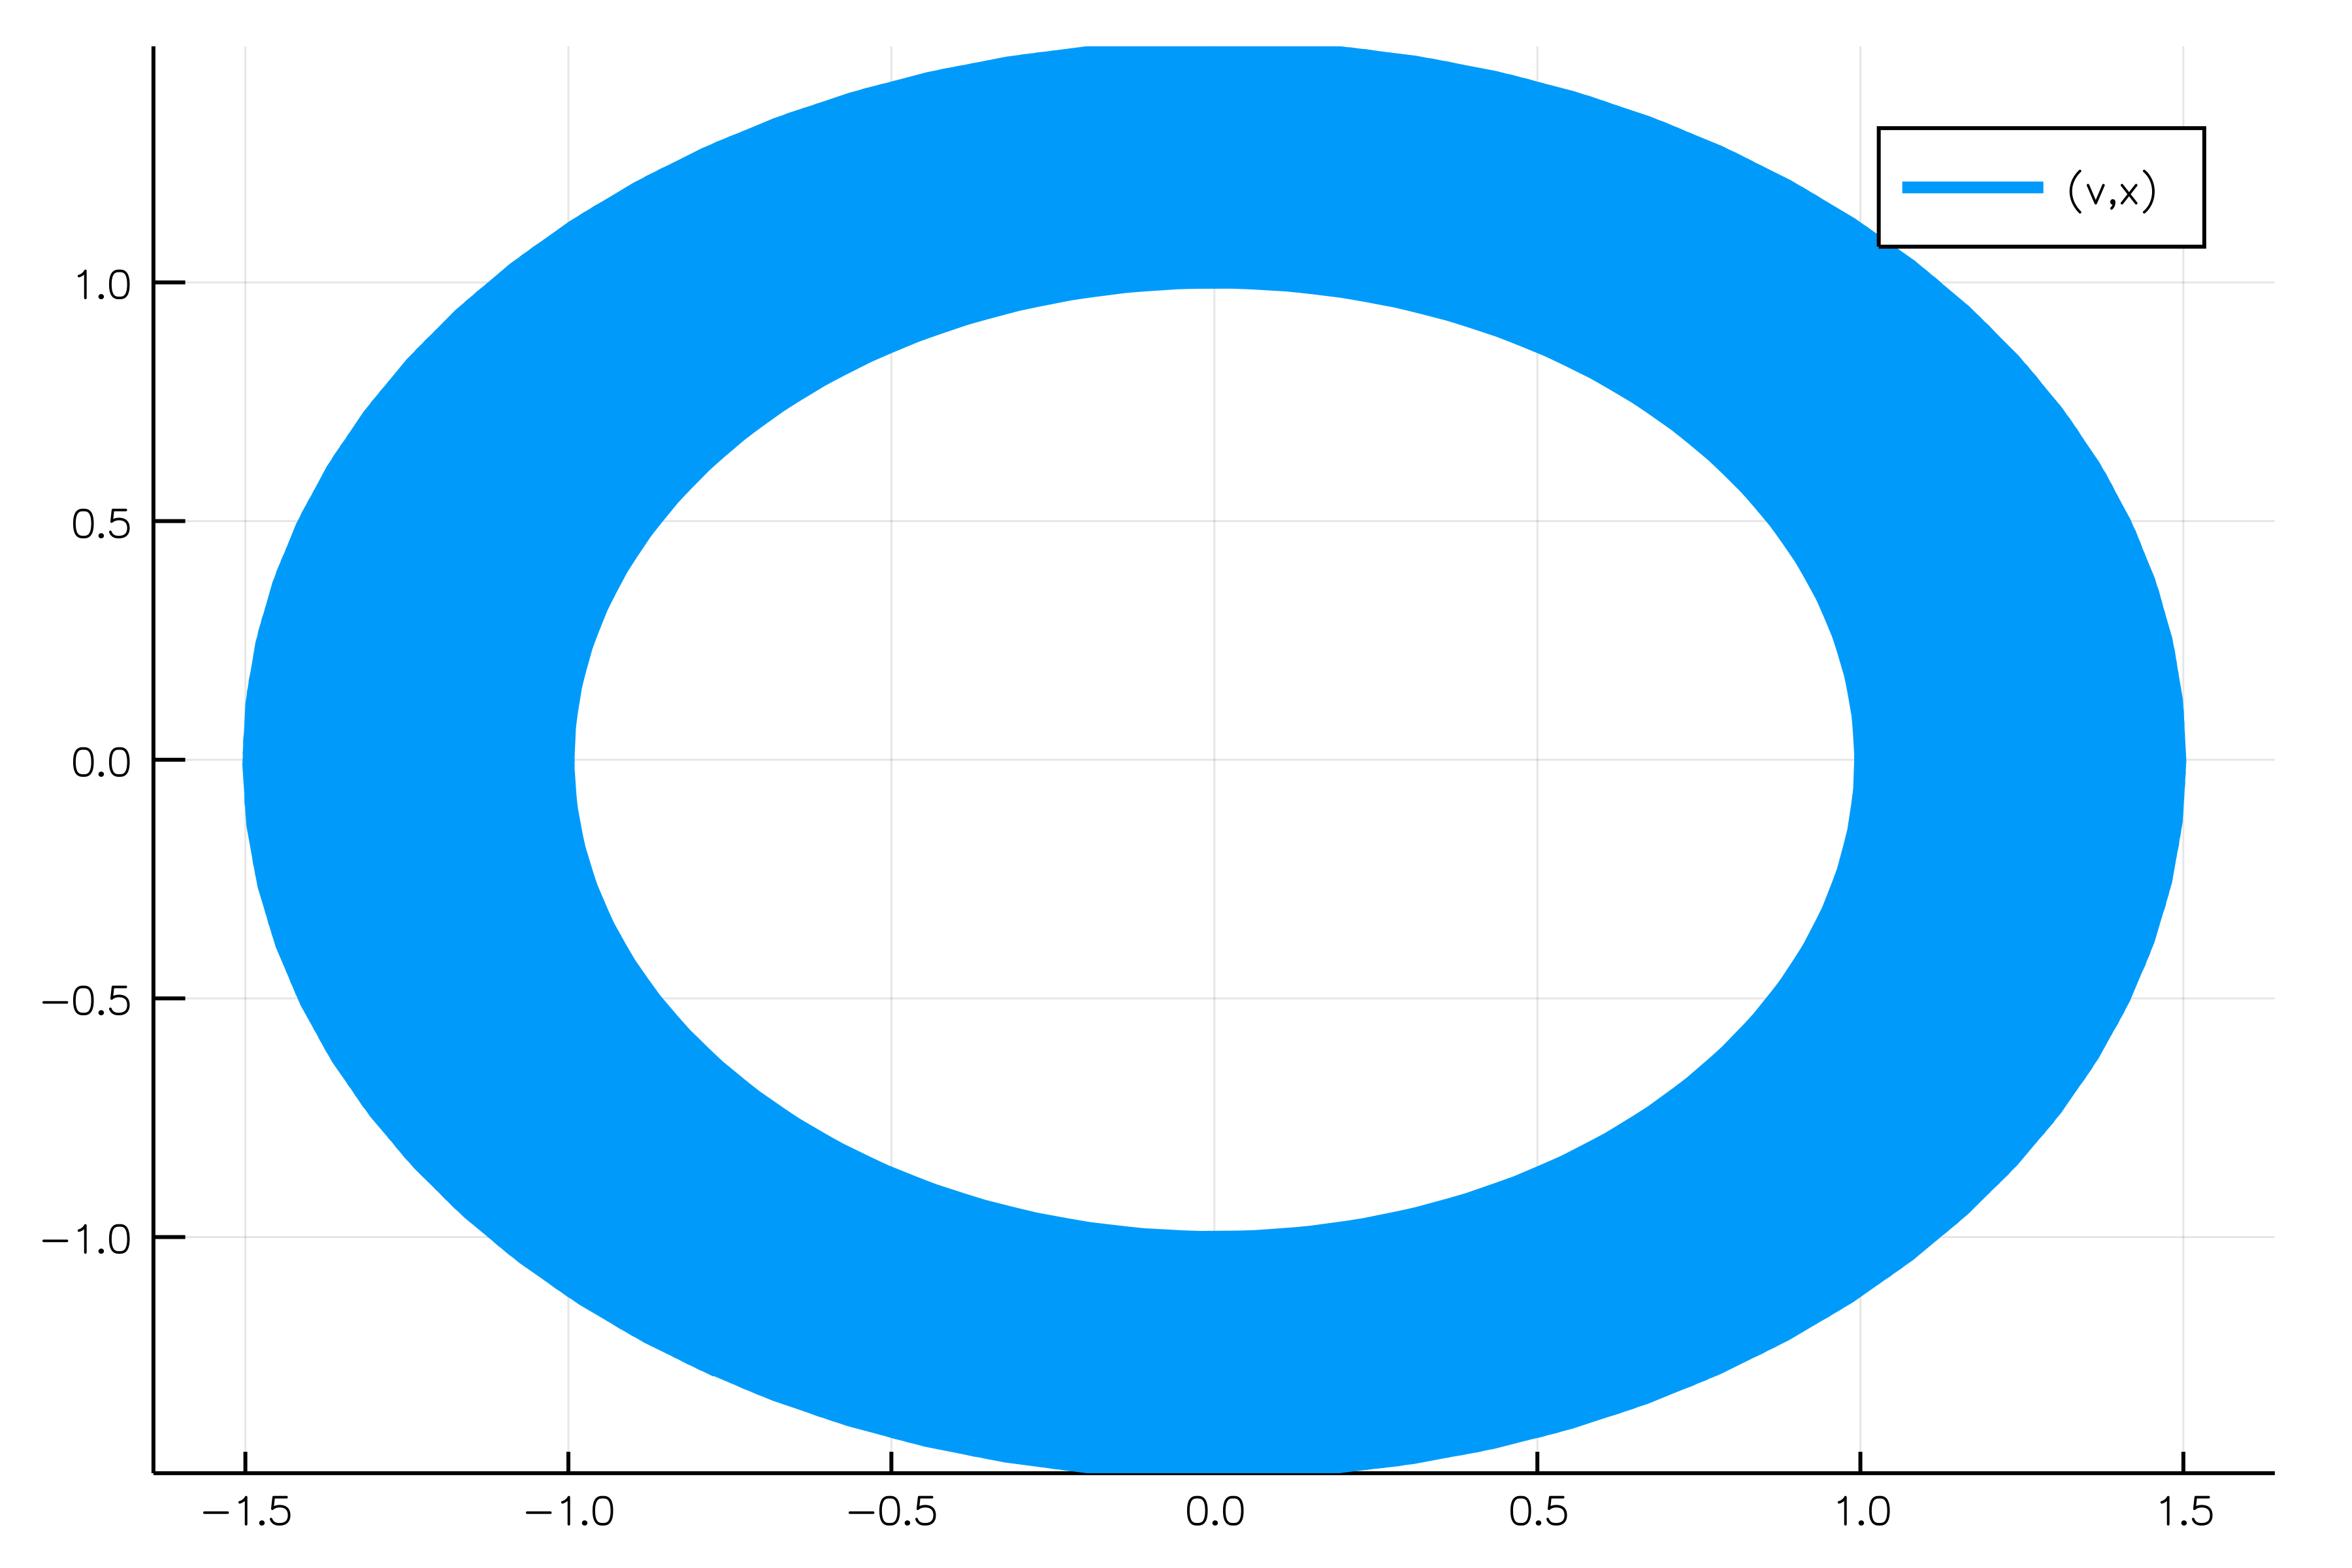

In [141]:
tspan = (0.0,10000.0)
prob = ODEProblem(harmonic!,u0,tspan)
sol = solve(prob)
gr(fmt=:png) # Make it a PNG instead of an SVG since there's a lot of points!
plot(sol,vars=(1,2))


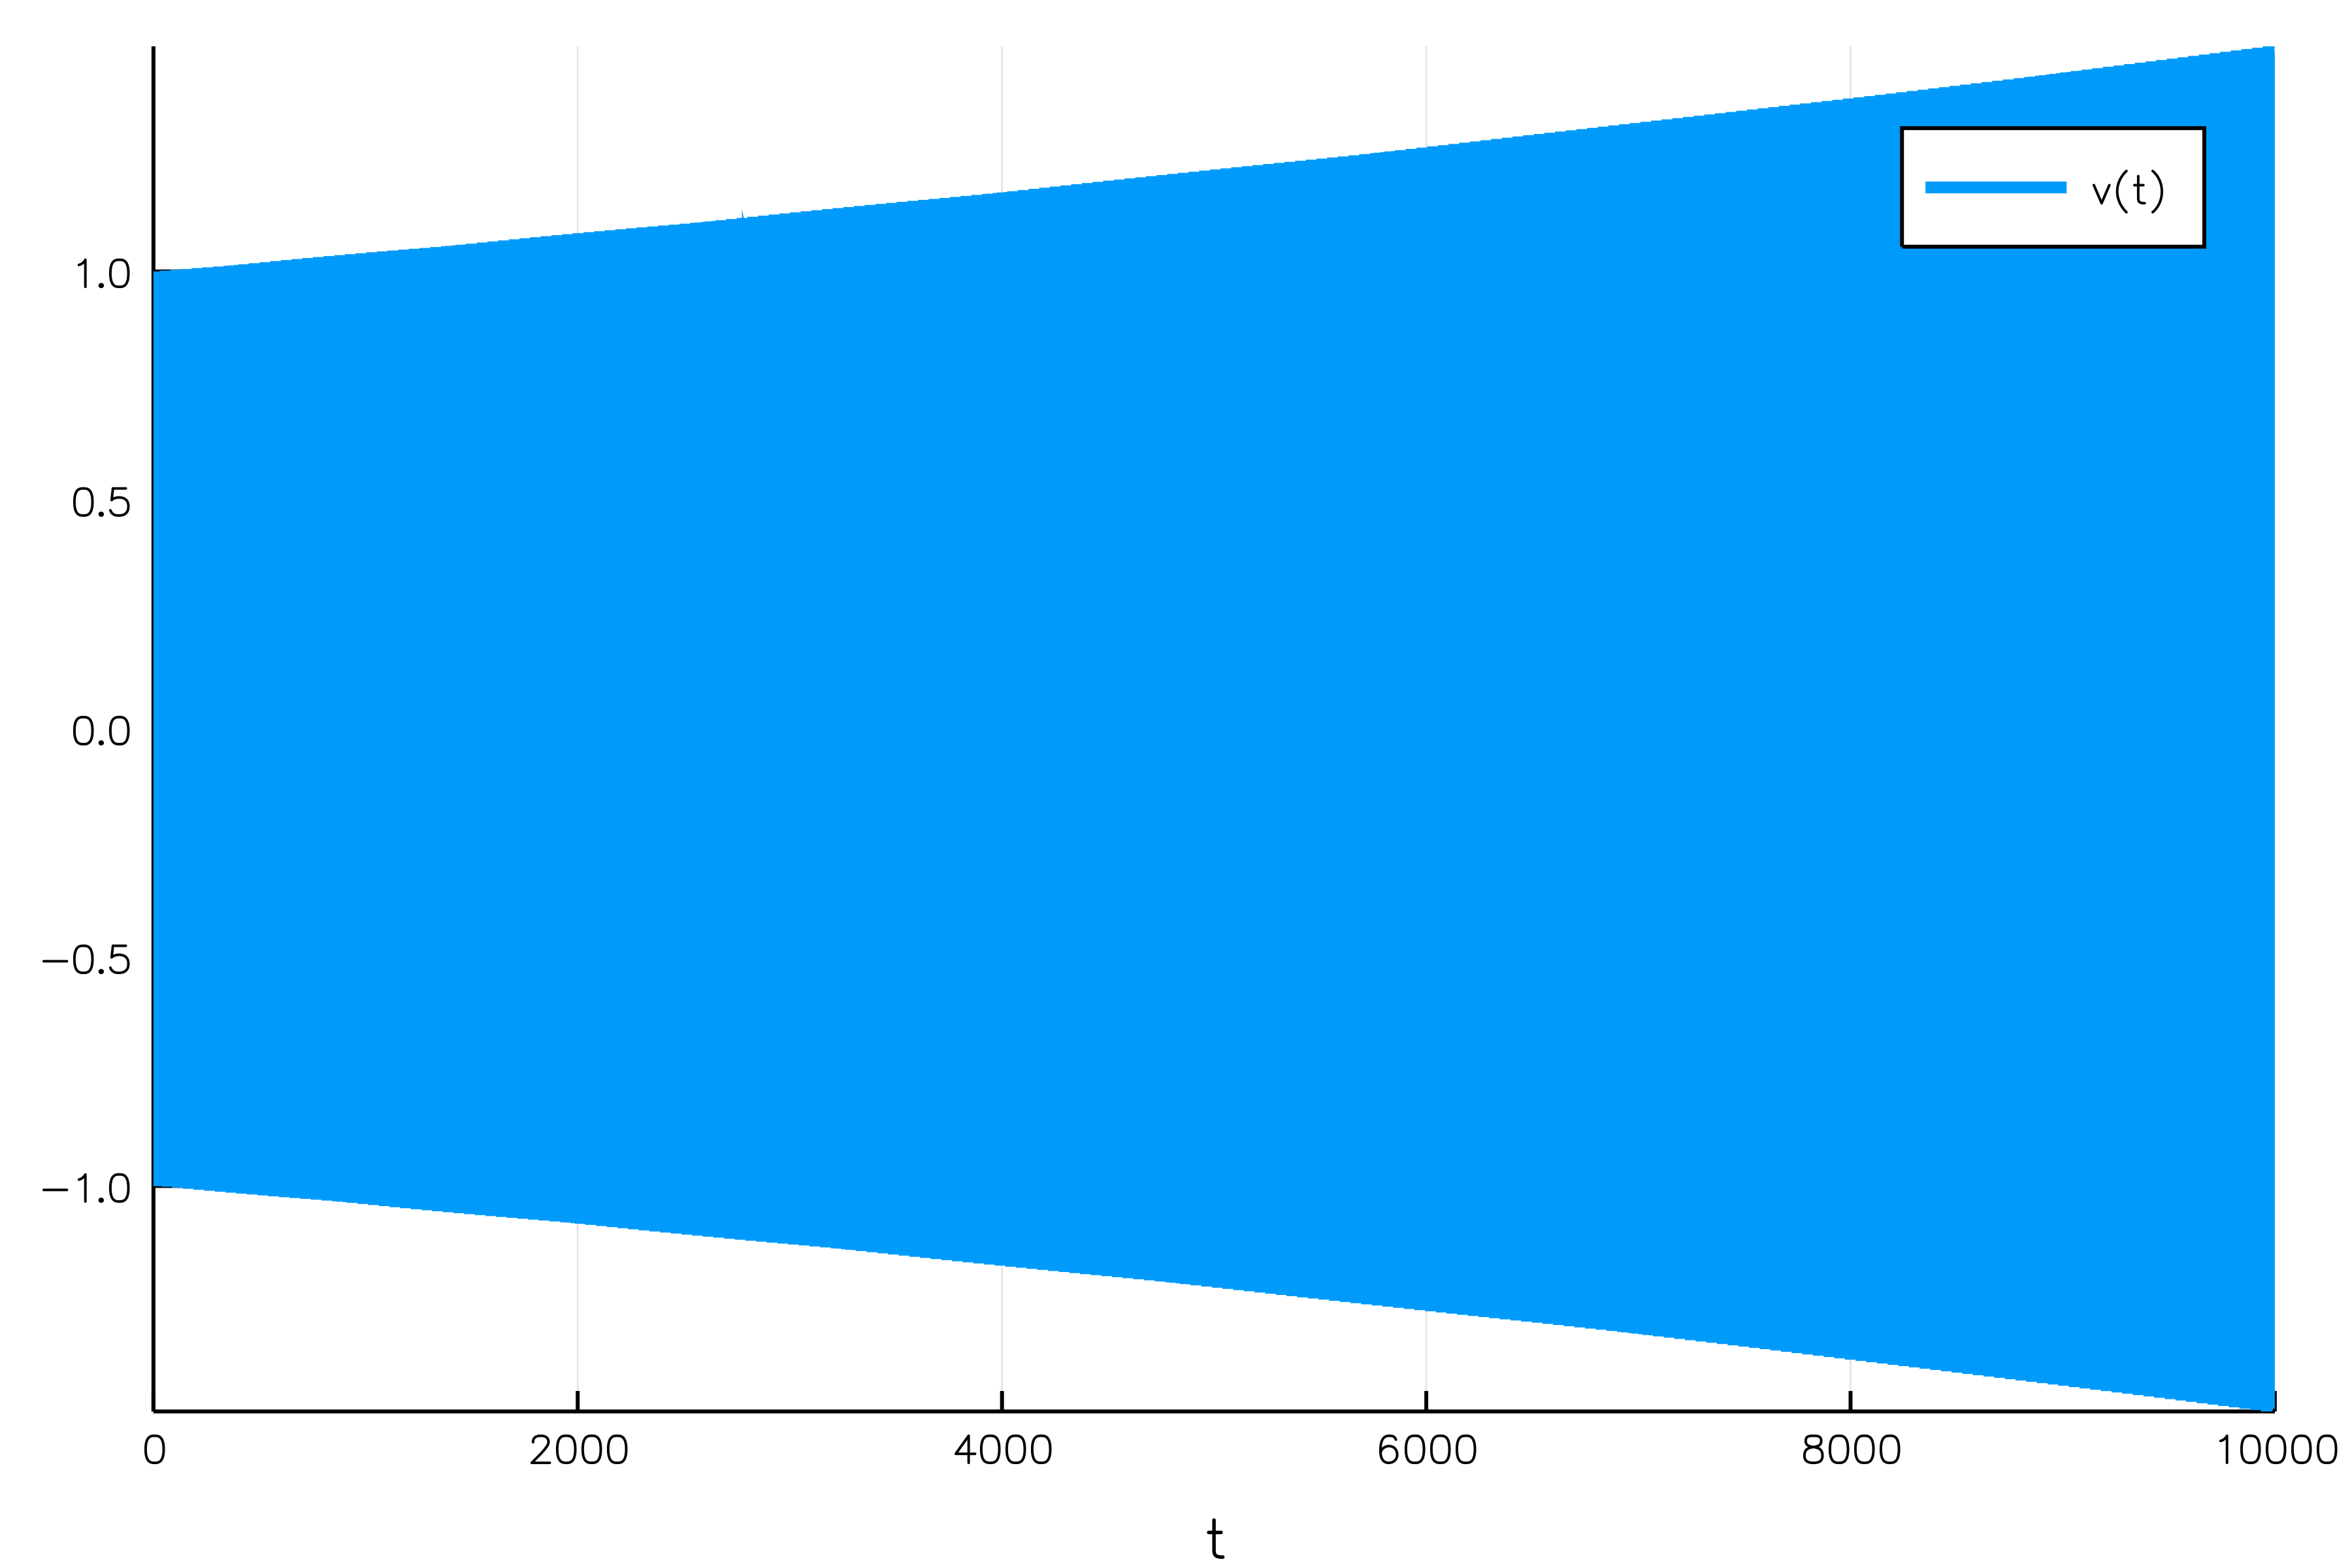

In [132]:
plot(sol,vars=(0,1),denseplot=false)

Notice that what's going on is that the numerical solution is drifting from the true solution over this long time scale. This is because the integrator is not conserving energy.


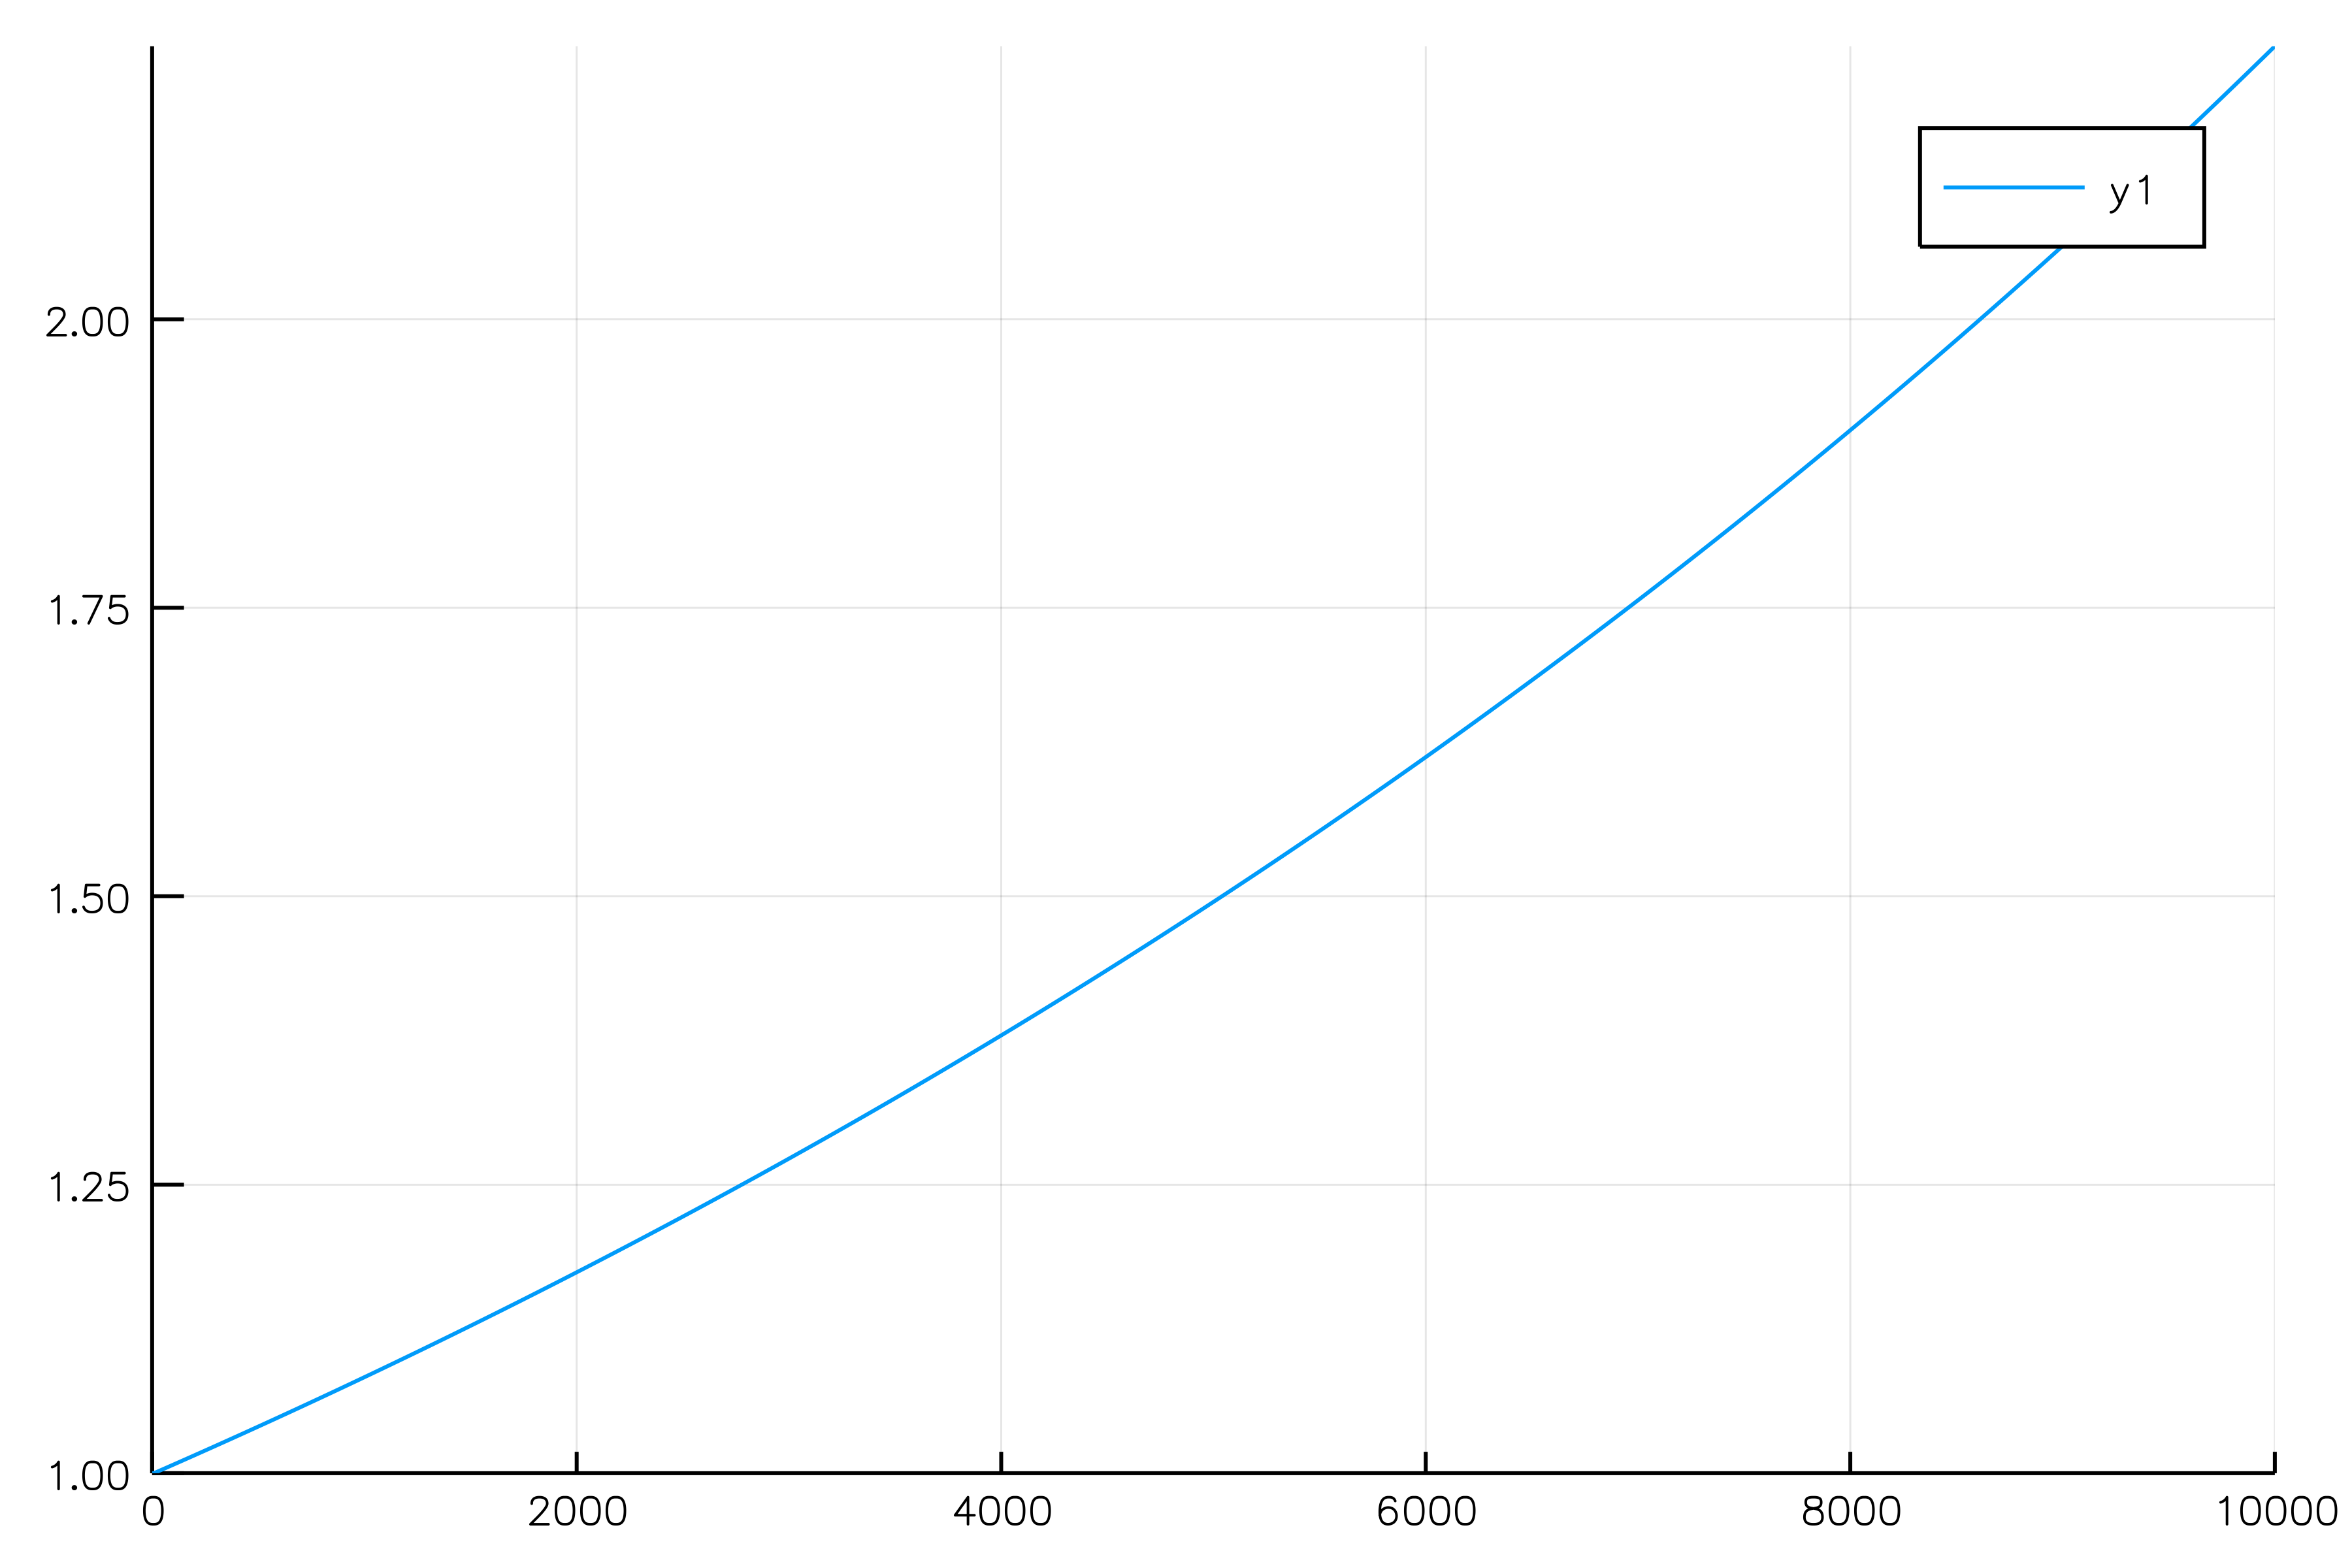

In [143]:
plot(sol.t,[u[2]^2 + u[1]^2 for u in sol.u]) # Energy ~ x^2 + v^2

Some integration techniques like [symplectic integrators](http://docs.juliadiffeq.org/latest/solvers/dynamical_solve.html#Symplectic-Integrators-1) are designed to mitigate this issue, but instead let's tackle the problem by enforcing conservation of energy. To do so, we define our manifold as the one where energy equals 1 (since that holds in the initial condition), that is:

In [134]:
function g(resid,u,p,t)
  resid[1] = u[2]^2 + u[1]^2 - 1
  resid[2] = 0
end

g (generic function with 1 method)

Here the residual measures how far from our desired energy we are, and the number of conditions matches the size of our system (we ignored the second one by making the residual 0). Thus we define a `ManifoldProjection` callback and add that to the solver:


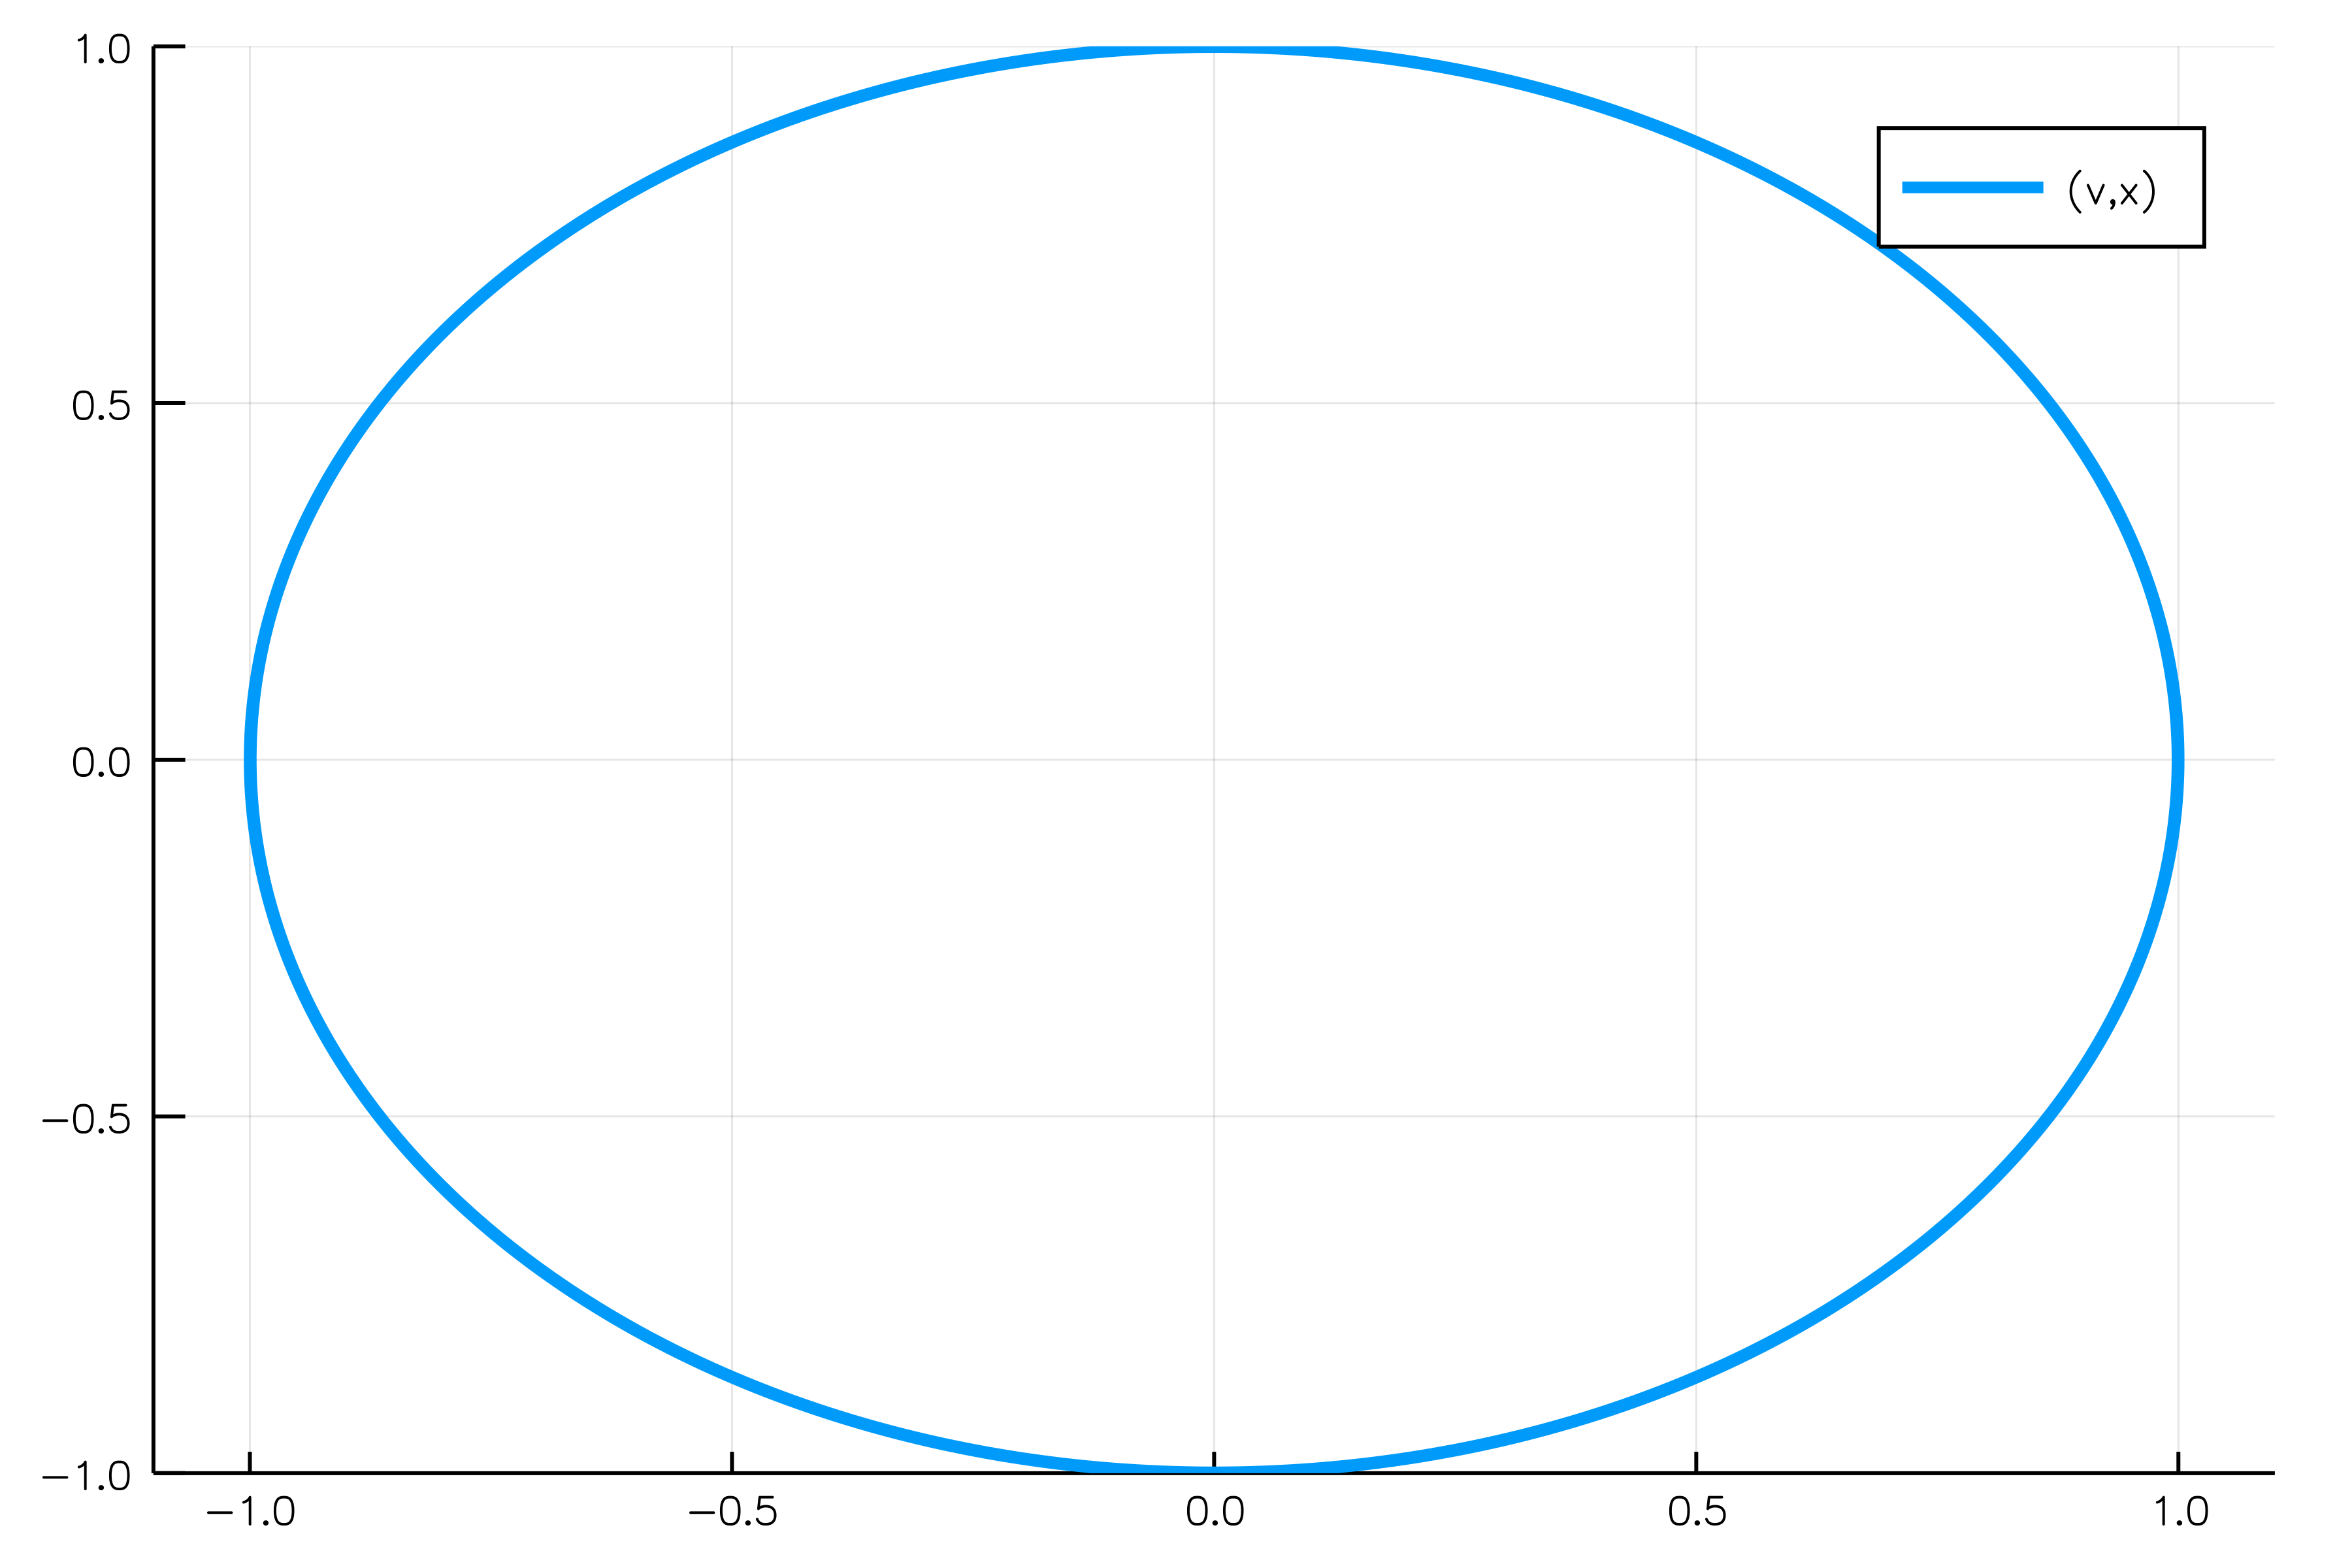

In [137]:
cb = ManifoldProjection(g)
sol = solve(prob,callback=cb)
plot(sol,vars=(1,2))


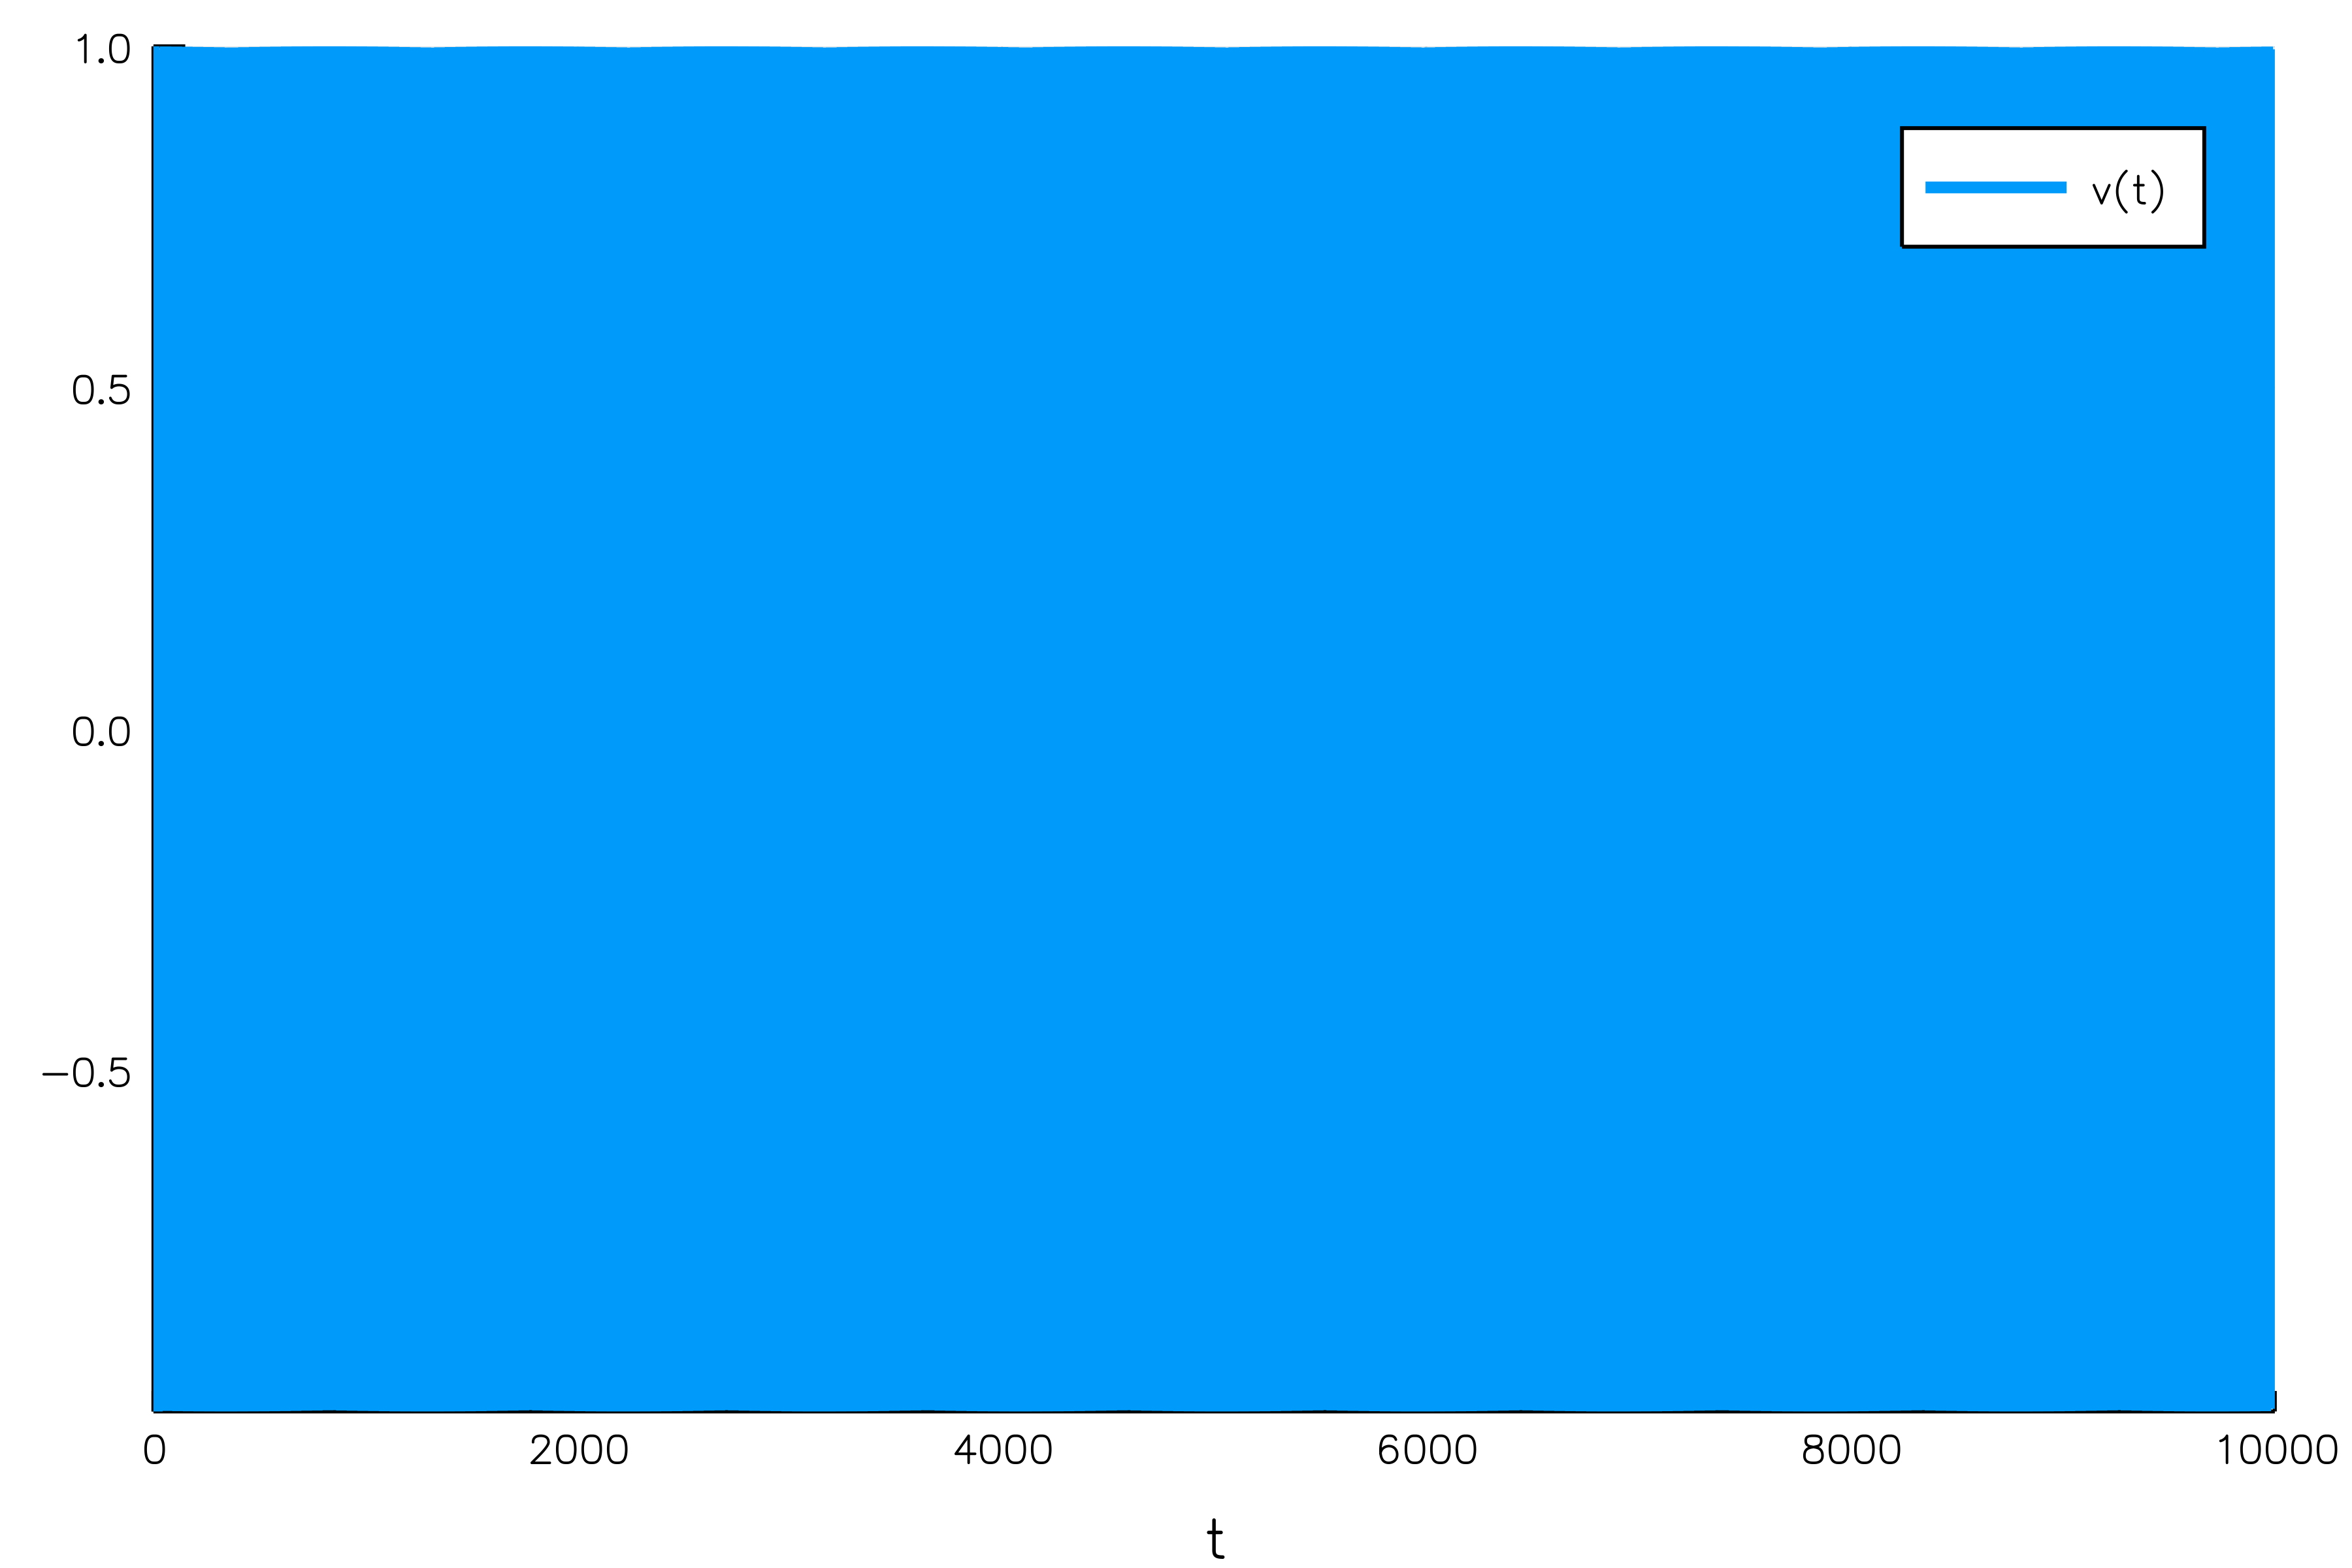

In [138]:
plot(sol,vars=(0,1),denseplot=false)

Now we have "perfect" energy conservation, where if it's ever violated too much the solution will get projected back to `energy=1`.

In [140]:
u1,u2 = sol[500]
u2^2 + u1^2

1.000000000579175

While choosing different integration schemes and using lower tolerances can achieve this effect as well, this can be a nice way to enforce physical constraints and is thus used in many disciplines like molecular dynamics. Another such domain constraining callback is the [`PositiveCallback()`](http://docs.juliadiffeq.org/latest/features/callback_library.html#PositiveDomain-1) which can be used to enforce positivity of the variables.

### SavingCallback

The `SavingCallback` can be used to allow for special saving behavior. Let's take a linear ODE define on a system of 1000x1000 matrices:

In [144]:
prob = ODEProblem((du,u,p,t)->du.=u,rand(1000,1000),(0.0,1.0))

DiffEqBase.ODEProblem with uType Array{Float64,2} and tType Float64. In-place: true
timespan: (0.0, 1.0)
u0: [0.274156 0.19674 … 0.283458 0.887401; 0.171726 0.327123 … 0.080116 0.894558; … ; 0.145367 0.8893 … 0.0706464 0.931397; 0.0435507 0.668118 … 0.851025 0.421555]

In fields like quantum mechanics you may only want to know specific properties of the solution such as the trace or the norm of the matrix. Saving all of the 1000x1000 matrices can be a costly way to get this information! Instead, we can use the `SavingCallback` to save the `trace` and `norm` at specified times. To do so, we first define our `SavedValues` cache. Our time is in terms of `Float64`, and we want to save tuples of `Float64`s (one for the `trace` and one for the `norm`), and thus we generate the cache as:

In [145]:
saved_values = SavedValues(Float64, Tuple{Float64,Float64})

SavedValues{tType=Float64, savevalType=Tuple{Float64,Float64}}
t:
Float64[]
saveval:
Tuple{Float64,Float64}[]

Now we define the `SavingCallback` by giving it a function of `(u,p,t,integrator)` that returns the values to save, and the cache:

In [149]:
cb = SavingCallback((u,t,integrator)->(trace(u),norm(u)), saved_values)

DiffEqBase.DiscreteCallback{DiffEqCallbacks.##30#31,DiffEqCallbacks.SavingAffect{##12#13,Float64,Tuple{Float64,Float64},DataStructures.BinaryHeap{Float64,DataStructures.LessThan},Array{Float64,1}},DiffEqCallbacks.#saving_initialize}(DiffEqCallbacks.#30, DiffEqCallbacks.SavingAffect{##12#13,Float64,Tuple{Float64,Float64},DataStructures.BinaryHeap{Float64,DataStructures.LessThan},Array{Float64,1}}(#12, SavedValues{tType=Float64, savevalType=Tuple{Float64,Float64}}
t:
[0.0]
saveval:
Tuple{Float64,Float64}[], DataStructures.BinaryHeap{Float64,DataStructures.LessThan}(DataStructures.LessThan(), Float64[]), Float64[], true, true, 0), DiffEqCallbacks.saving_initialize, (false, false))

Here we take `u` and save `(trace(u),norm(u))`. When we solve with this callback:

In [151]:
sol = solve(prob, Tsit5(), callback=cb, save_everystep=false, save_start=false, save_end = false) # Turn off normal saving

retcode: Success
Interpolation: 1st order linear
t: 0-element Array{Float64,1}
u: 0-element Array{Array{Float64,2},1}

Our values are stored in our `saved_values` variable:

In [152]:
saved_values.t

5-element Array{Float64,1}:
 0.0     
 0.100129
 0.348391
 0.683737
 1.0     

In [153]:
saved_values.saveval

5-element Array{Tuple{Float64,Float64},1}:
 (501.371, 500.197)
 (554.172, 552.874)
 (710.335, 708.672)
 (993.35, 991.024) 
 (1362.87, 1359.68)

By default this happened only at the solver's steps. But the `SavingCallback` has similar controls as the integrator. For example, if we want to save at every `0.1` seconds, we do can so using `saveat`:

In [157]:
saved_values = SavedValues(Float64, Tuple{Float64,Float64}) # New cache
cb = SavingCallback((u,t,integrator)->(trace(u),norm(u)), saved_values, saveat = 0.0:0.1:1.0)
sol = solve(prob, Tsit5(), callback=cb, save_everystep=false, save_start=false, save_end = false) # Turn off normal saving

retcode: Success
Interpolation: 1st order linear
t: 0-element Array{Float64,1}
u: 0-element Array{Array{Float64,2},1}

In [158]:
saved_values.t

11-element Array{Float64,1}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

In [159]:
saved_values.saveval

11-element Array{Tuple{Float64,Float64},1}:
 (501.371, 500.197)
 (554.101, 552.803)
 (612.376, 610.942)
 (676.78, 675.195) 
 (747.958, 746.206)
 (826.621, 824.685)
 (913.557, 911.418)
 (1009.64, 1007.27)
 (1115.82, 1113.21)
 (1233.17, 1230.29)
 (1362.87, 1359.68)

#### Exercise 3

Go back to the Harmonic oscillator. Use the `SavingCallback` to save an array for the energy over time, and do this both with and without the `ManifoldProjection`. Plot the results to see the difference the projection makes.